# Defacing pre-registration - Exploratory analysis in R

## Load manual ratings

In [76]:
# Load ratings
df <- read.csv("../../data/IXI_augmented_ratings_df.tsv", sep="\t")
head(df)

randomized_id rater_id dataset                         rating time_sec
1 sub-0152_T1w  rater_02 IXI dataset - MRIQC derivatives 2.55   314.549 
2 sub-1051_T1w  rater_02 IXI dataset - MRIQC derivatives 2.85   150.737 
3 sub-1186_T1w  rater_02 IXI dataset - MRIQC derivatives 2.55   104.950 
4 sub-0951_T1w  rater_02 IXI dataset - MRIQC derivatives 3.45    84.569 
5 sub-0902_T1w  rater_02 IXI dataset - MRIQC derivatives 2.95    68.889 
6 sub-0250_T1w  rater_02 IXI dataset - MRIQC derivatives 2.55    90.318 
  artifacts                                           confidence
1 ["noise-global","inu","processing","uncategorized"] 2.50      
2 ["noise-local","processing"]                        3.50      
3 ["wrap-around","uncategorized"]                     3.35      
4 ["inu"]                                             3.50      
5 ["processing"]                                      3.50      
6 ["uncategorized"]                                   3.15      
  comments                                                                                     
1 blurry, smooth image, A bit of signal dropout in frontal                                     
2 Smooth. but seems to be the case of most of the images of the dataset                        
3 Slightly short FoV in frontal, bordeline cutting the cortex, Small artefact in the background
4                                                                                              
5                                                                                              
6 looks like a bit of drop out in frontal and a bit of background artefact                     
  defaced subject
1 1        72    
2 0       354    
3 0       205    
4 1       446    
5 1       248    
6 0       437

Let us verify that each rater rated all 450 images.

In [77]:
raters <- list('rater_01', 'rater_02', 'rater_03', 'rater_04')
for (rater in raters) {
  df_rater <- subset(df, rater_id == rater)
  # If an image was assigned several ratings by the same rater, we keep only the last one
  df_unique <- df_rater[!duplicated(df_rater[c("rater_id", "randomized_id")], fromLast = TRUE), ]
  print(paste(rater, ":", nrow(df_unique), "images rated"))
}

[1] "rater_01 : 450 images rated"
[1] "rater_02 : 450 images rated"
[1] "rater_03 : 450 images rated"
[1] "rater_04 : 450 images rated"


In [78]:
library(dplyr)

# Remove information we will not use in this analysis
df <- subset(df, select = c("rater_id", "rating", "defaced", "subject"))

# Add a column rater_label for pretty printing of the rater_id
df <- df %>%
  mutate(rater_label = gsub("rater_", "Rater ", rater_id))

#Plot just the first few rows for making the notebook less lengthy
head(df)

rater_id rating defaced subject rater_label
1 rater_02 2.55   1        72     Rater 02   
2 rater_02 2.85   0       354     Rater 02   
3 rater_02 2.55   0       205     Rater 02   
4 rater_02 3.45   1       446     Rater 02   
5 rater_02 2.95   1       248     Rater 02   
6 rater_02 2.55   0       437     Rater 02

# Plot ratings distribution

In [79]:
# Convert defaced to factor for better visualization
df$defaced <- factor(df$defaced, levels = c(0, 1), labels = c("Nondefaced", "Defaced"))

To explore whether a bias is visible in the data, we plot for each rater the distribution of the ratings extracted from non-defaced versus defaced images.

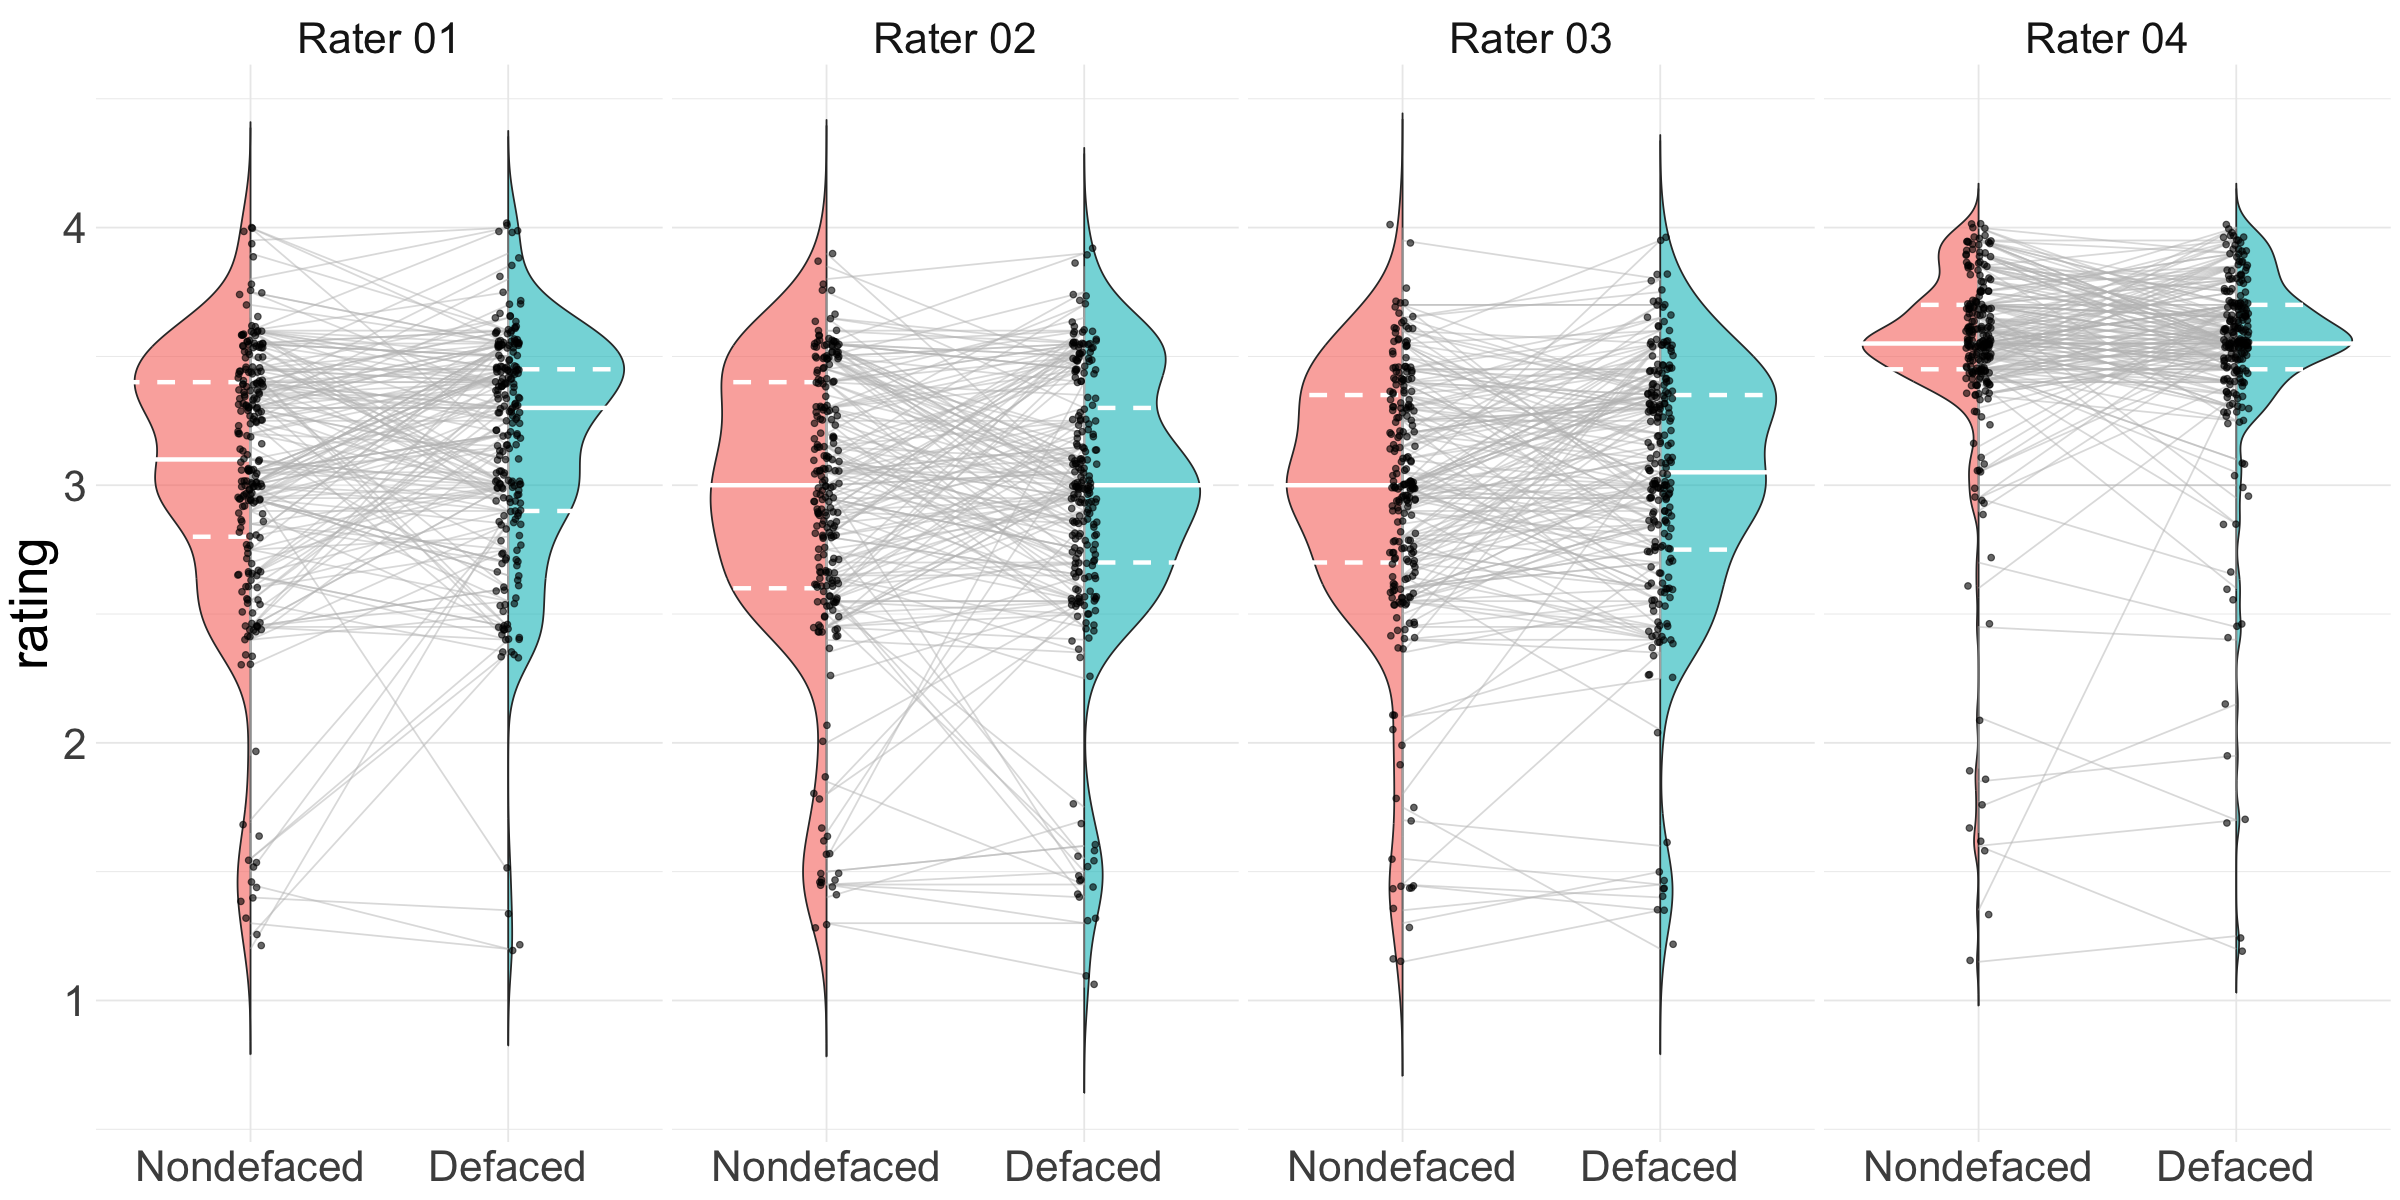

In [80]:
library(see)
library(ggplot2)
options(repr.plot.width=20, repr.plot.height=10)

# Plot
p <- ggplot(df, aes(x = defaced, y = rating, group = defaced)) +
  geom_violinhalf(aes(fill = defaced), trim = FALSE, scale = "width", alpha = 0.6, flip = c(0, 1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width = 1, color = "white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width = 1, color = "white", linetype = "dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.position = "none") +
  theme(axis.title.x = element_blank()) +
  facet_wrap(~ rater_label, ncol = 4)

print(p)

## Bland-Altman plot

In [81]:
library(tidyr)

color_1 <- "#F5C241"
#color_12 <- "#ddd0af"
color_12 <- "#EDDAAA"
color_2 <- "#643296"
color_22 <- "#A695B8"
color_reliable <- "grey"
line_color <- "black"

In [82]:
library(dplyr)
#Helper function to generate BA plot
ba_plot_defacing <- function(df, title, rater, point_size = 2.5, color_1="#F5C241", color_2="#643296", line_color="grey", yaxis = "diff") {

  # Pivot to wide format
  df_wide_ba <- df %>%
      pivot_wider(names_from = defaced, values_from = rating, values_fn = list)

  #Decouple the duplicates by writing the first image rating in one line and the second in a new line
  df_wide_ba <- df_wide_ba %>%
    unnest(cols = c("Nondefaced", "Defaced"))

  df_wide_ba <- df_wide_ba %>%
    mutate(mean = Nondefaced,
          diff = Nondefaced - Defaced,
          pt_color = case_when(
            diff < -0.5 ~ color_2,
            diff > 0.5 ~ color_1,
            diff > 0.1 ~ color_12,
            diff < -0.1 ~ color_22,
            TRUE ~ color_reliable
          ))

  if (!missing(rater)) {
    #Keep only the rows corresponding to the rater
    df_rater <- subset(df, rater_id == rater)

    #Pivot to wide format
    df_rater_wide <- df_rater %>%
      pivot_wider(names_from = defaced, values_from = rating, values_fn = list)

    #Decouple the duplicates by writing the first image rating in one line and the second in a new line
    df_rater_wide <- df_rater_wide %>%
      unnest(cols = c("Nondefaced", "Defaced"))

    #Create a new column encoding the mean and color to plot the points
    df_rater_wide <- df_rater_wide %>%
      mutate(mean = Nondefaced,
            diff = Nondefaced - Defaced,
            pt_color = case_when(
              diff < -0.5 ~ color_2,
              diff > 0.5 ~ color_1,
              diff > 0.1 ~ color_12,
              diff < -0.1 ~ color_22,
              TRUE ~ color_reliable
          ))

    # Calculate mean difference and 1.96 times the standard deviation of the differences
    mean_diff <- mean(df_rater_wide$diff)
    sd_diff <- sd(df_rater_wide$diff)
    upper_limit <- mean_diff + 1.96 * sd_diff
    lower_limit <- mean_diff - 1.96 * sd_diff

    if (yaxis == "diff"){
    ba <- ggplot(df_rater_wide, aes(x = mean, y = diff)) +
      geom_point(data = df_wide_ba, aes(x = mean, y = diff, color="#d9d9d9"), alpha = 0.3, size=point_size) +
      geom_point(size = point_size, aes(color = pt_color))
    } else if (yaxis == "defaced") {
      ba <- ggplot(df_rater_wide, aes(x = mean, y = Defaced)) +
      geom_point(data = df_wide_ba, aes(x = mean, y = Defaced, color="#d9d9d9"), alpha = 0.3, size = point_size) +
      geom_point(size = point_size, aes(color = pt_color)) +
      geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", color = color_reliable)
    }
  } else {
    # Calculate mean difference and 1.96 times the standard deviation of the differences
    mean_diff <- mean(df_wide_ba$diff)
    sd_diff <- sd(df_wide_ba$diff)
    upper_limit <- mean_diff + 1.96 * sd_diff
    lower_limit <- mean_diff - 1.96 * sd_diff

    if (yaxis == "diff"){
      ba <- ggplot(df_wide_ba, aes(x = mean, y = diff)) +
        geom_point(size = point_size +1, aes(color = pt_color))
    } else if (yaxis == "defaced") {
      ba <- ggplot(df_wide_ba, aes(x = mean, y = Defaced)) +
        geom_point(size = point_size +1, aes(color = pt_color)) +
        geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", color = color_reliable)
    }
  }

  ba <- ba +
    # geom_hline(yintercept = 0, color = "#7f7f7f", linetype = "solid", size = 1) +
    # geom_hline(yintercept = mean_diff, color = line_color, linetype = "solid", size = 1) +
    # geom_hline(yintercept = upper_limit, color = line_color, linetype = "dashed", size = 1) +
    # geom_hline(yintercept = lower_limit, color = line_color, linetype = "dashed", size = 1) +
    scale_color_identity() +
    theme(legend.position = "none") +
    # theme(text = element_text(size = 19, face="bold")) +
    theme(
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
    ) +
    theme(panel.background = element_blank()) +
    xlab("") +
    ylab("")

  if (!missing(title)) {
    # ba <- ba + ggtitle(title)
    write_y <- if (yaxis == "diff") 2.0 else 4.4
    ba <- ba + annotate(
      "text",
      label = title,
      x = 3.9, # max(df_wide_ba$Nondefaced),
      y = write_y,  # min(df_wide_ba$diff),
      hjust = 1,
      size = 10,
      fontface = 2,
    )
  }

  if (yaxis=="diff"){
    ba <- ba + 
      xlim(0.9, 4.1) +
      ylim(-2.1, 2.1)
  }

  return(ba)
}

### Bland-Altman plot with difference in y-axis

TableGrob (2 x 7) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-2,1-3) arrange gtable[layout]
2 2 (1-1,4-5) arrange gtable[layout]
3 3 (1-1,6-7) arrange gtable[layout]
4 4 (2-2,4-5) arrange gtable[layout]
5 5 (2-2,6-7) arrange gtable[layout]


Saving 7 x 7 in image


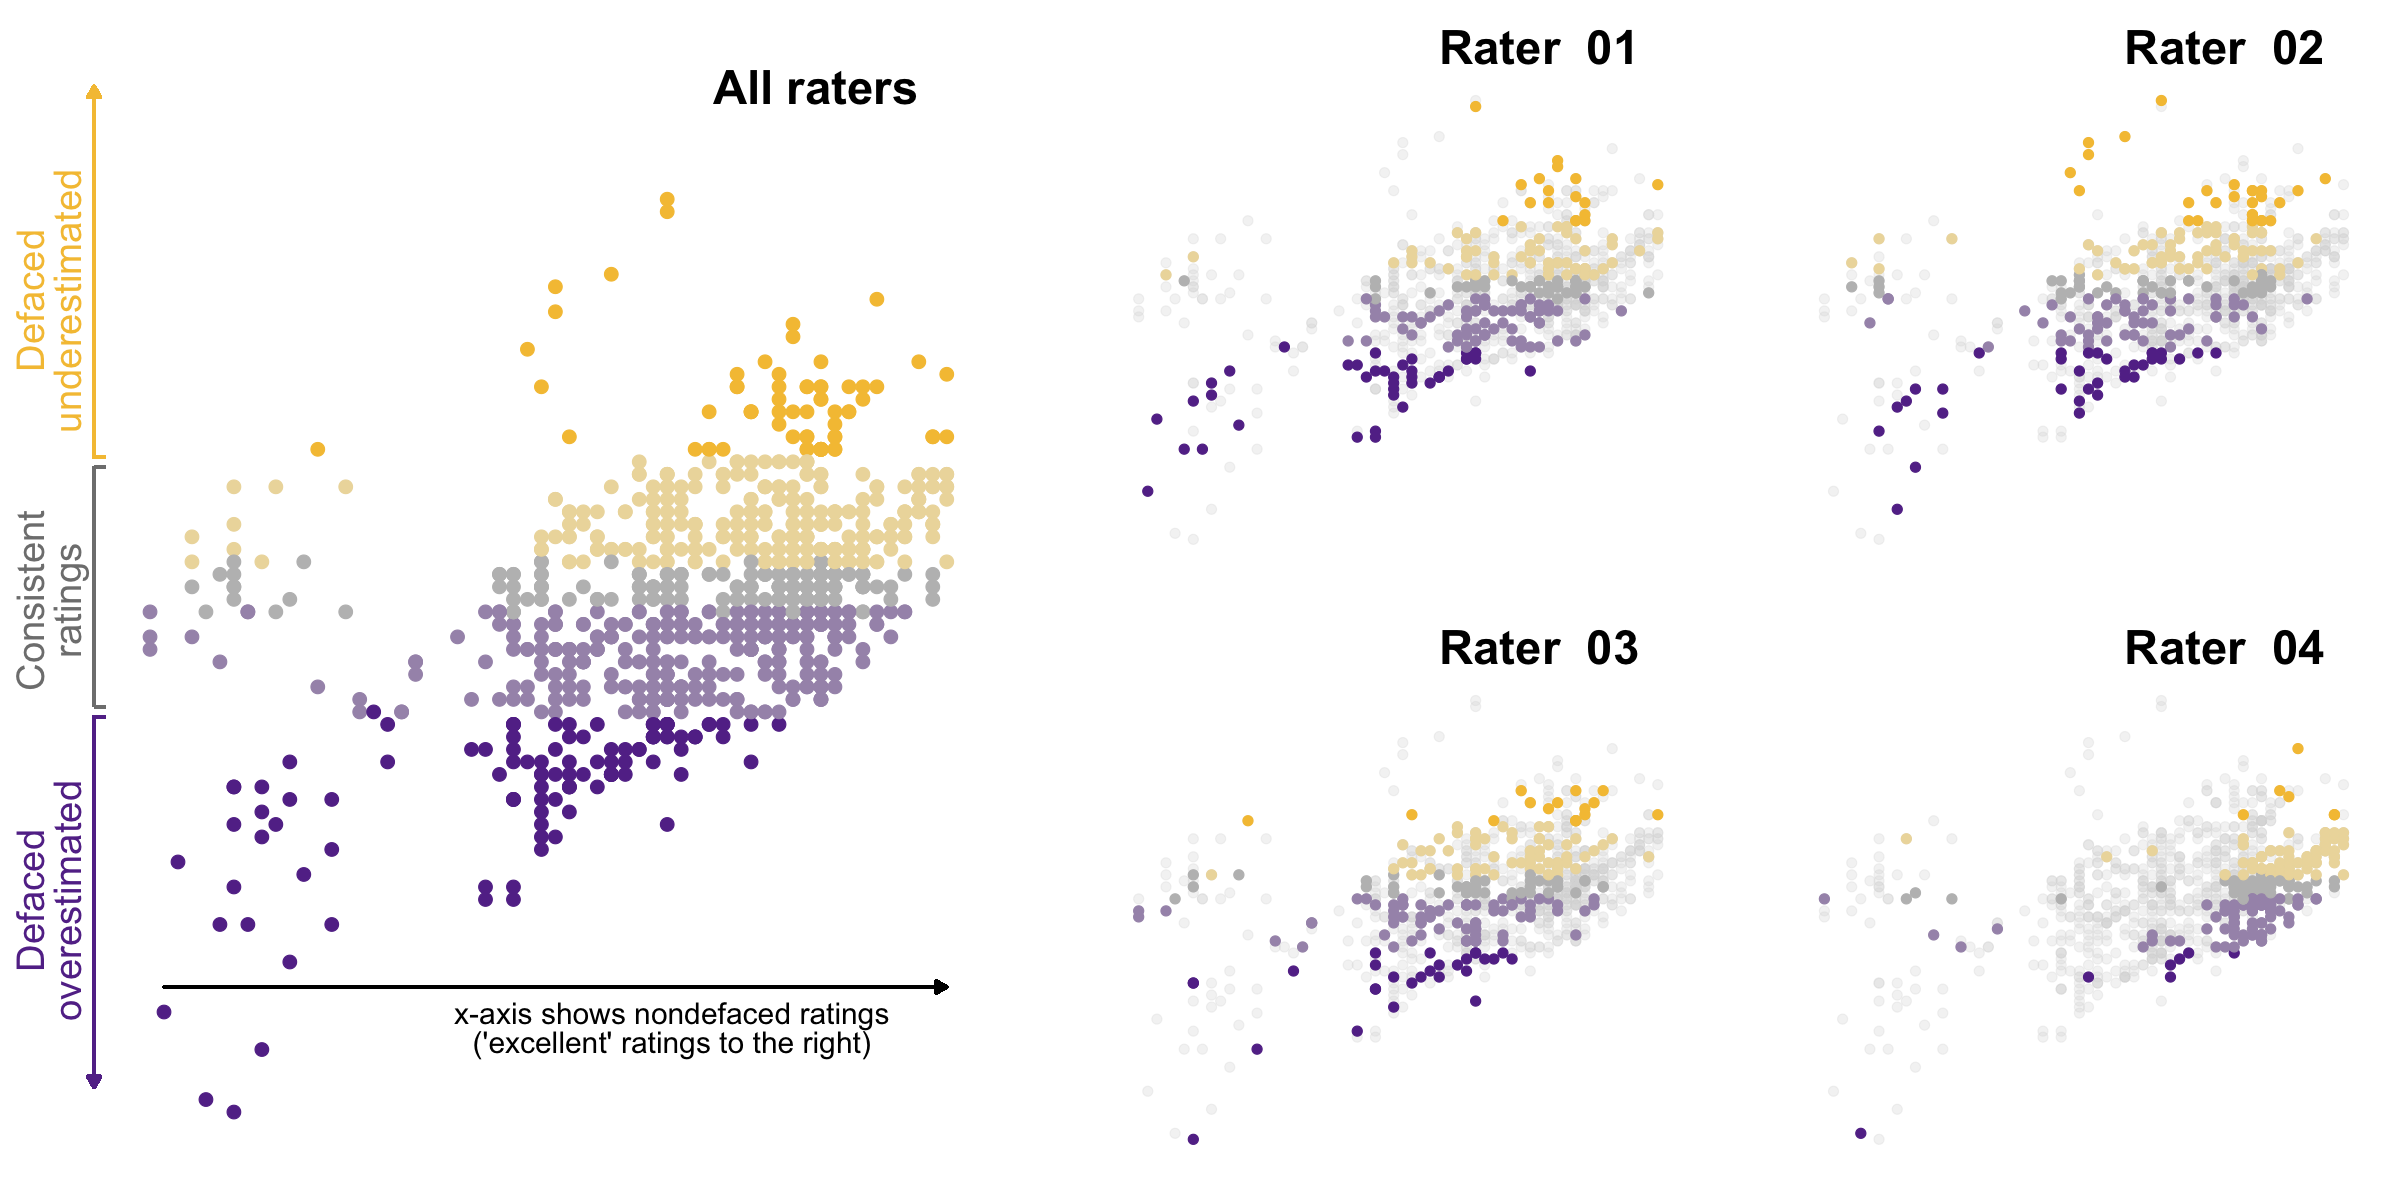

In [83]:
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(scales)
options(repr.plot.width=20, repr.plot.height=10)

plot_list <- list()

point_size <- 2.5

## BA plot with all raters
ba_all <- ba_plot_defacing(df = df, title = "All raters")

ba_all <- ba_all +
    geom_segment(
      x = 0.95, y = 0.52,
      xend = 0.95, yend = 2.0,
      lineend = "round", # See available arrow types in example above
      linejoin = "round",
      size = 1, 
      arrow = arrow(length = unit(0.1, "inches"), type="closed"),
      colour = color_1,
    ) +
    geom_segment(
      x = 0.95, y = 0.52,
      xend = 0.99, yend = 0.52,
      color = color_1,
      size = 1
    ) +
    geom_segment(
      x = 0.95, y = -0.52,
      xend = 0.95, yend = -2.0,
      lineend = "round", # See available arrow types in example above
      linejoin = "round",
      size = 1, 
      arrow = arrow(length = unit(0.1, "inches"), type="closed"),
      colour = color_2,
    ) +
    geom_segment(
      x = 0.95, y = -0.52,
      xend = 0.99, yend = -0.52,
      color = color_2,
      size = 1
    ) +
    geom_segment(
      x = 0.95, y = -0.48,
      xend = 0.95, yend = 0.48,
      color = "#7f7f7f",
      size = 1
    ) +
    geom_segment(
      x = 0.95, y = -0.48,
      xend = 0.99, yend = -0.48,
      color = "#7f7f7f",
      size = 1
    ) +
    geom_segment(
      x = 0.95, y = 0.48,
      xend = 0.99, yend = 0.48,
      color = "#7f7f7f",
      size = 1
    ) +
    geom_segment(
      x = 1.2, y = -1.6,
      xend = 4.0, yend = -1.6,
      lineend = "round", # See available arrow types in example above
      linejoin = "round",
      size = 0.8, 
      arrow = arrow(length = unit(0.1, "inches"), type="closed"),
      colour = "black",
    )

plot_list <- c(list(ba_all), plot_list)

## BA for each rater
for (rater in sort(unique(df$rater_id))) {
  rater_title = paste("Rater ", strsplit(rater, "_")[[1]][[2]])
  ba  <- ba_plot_defacing(df = df, title = rater_title, rater = rater)
  plot_list <- c(plot_list, list(ba))
}

## Combine all plots
# x_grob <- textGrob("Reference rating (nondefaced condition)", gp = gpar(fontsize = 24), vjust = -0.2)
# y_grob <- textGrob("Δ Rating (nondefaced minus defaced)", gp = gpar(fontsize = 24), rot = 90, vjust = 0.7)
comment_grob <- textGrob(
  "Defaced\noverestimated",
  gp = gpar(fontsize = 23, col= color_2, lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.25,
  just = c("centre", "top"))
comment_grob_2 <- textGrob(
  "Defaced\nunderestimated",
  gp = gpar(fontsize = 23, col= color_1, lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.75,
  just = c("centre", "top"))
comment_grob_3 <- textGrob(
  "Consistent\nratings",
  gp = gpar(fontsize = 23, col = "#7f7f7f", lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.5,
  just = c("centre", "top"))
comment_grob_xaxis <- textGrob(
  "x-axis shows nondefaced ratings\n('excellent' ratings to the right)",
  gp = gpar(fontsize = 18, col = "black", lineheight = 0.8),
  x = 0.28,
  y = 0.165,
  just = c("centre", "top"))

lay <- rbind(c(1,1,1,2,2,3,3),
             c(1,1,1,4,4,5,5))
final_plot <- grid.arrange(
  grobs = plot_list,
  # bottom=x_grob,
  # left=y_grob,
  layout_matrix = lay,
  )
grid.draw(comment_grob)
grid.draw(comment_grob_2)
grid.draw(comment_grob_3)
grid.draw(comment_grob_xaxis)

print(final_plot)

ggsave(file="ba-plot.svg", plot=final_plot)

### Bland-Altman plot with defaced rating in y-axis

TableGrob (2 x 7) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-2,1-3) arrange gtable[layout]
2 2 (1-1,4-5) arrange gtable[layout]
3 3 (1-1,6-7) arrange gtable[layout]
4 4 (2-2,4-5) arrange gtable[layout]
5 5 (2-2,6-7) arrange gtable[layout]


Saving 7 x 7 in image


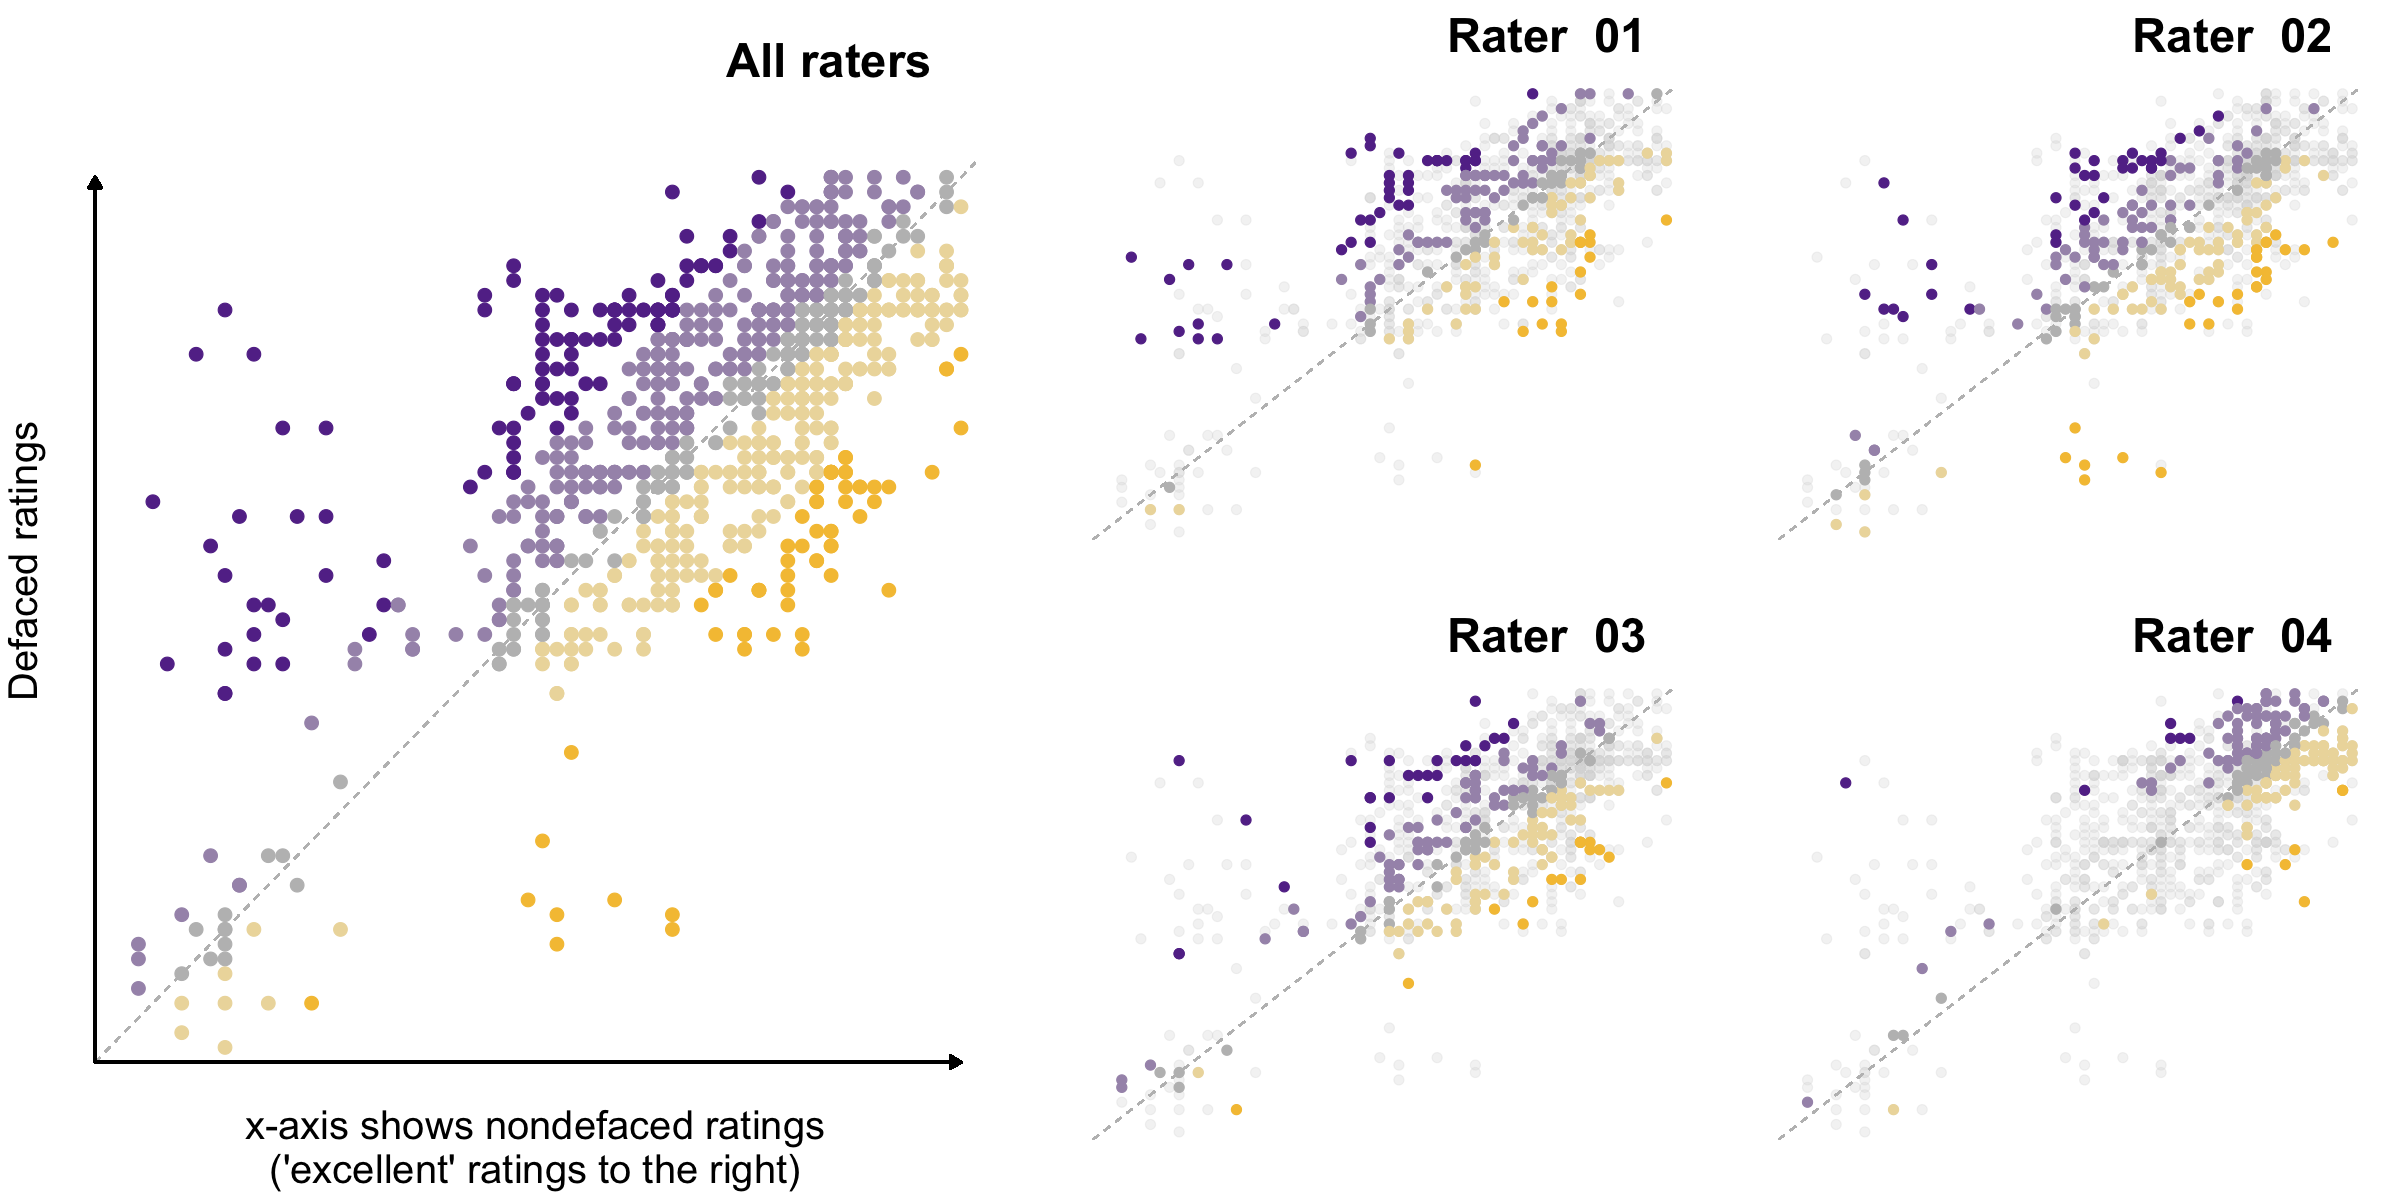

In [84]:
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(scales)
options(repr.plot.width=20, repr.plot.height=10)

plot_list <- list()

point_size <- 2.5

## BA plot with all raters
ba_all <- ba_plot_defacing(df = df, title = "All raters", yaxis = "defaced")

ba_all <- ba_all +
  geom_segment(
        x = 1, y = 1,
        xend = 4.0, yend = 1,
        lineend = "round", # See available arrow types in example above
        linejoin = "round",
        size = 0.8, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = "black",
      ) +
      xlab("x-axis shows nondefaced ratings\n('excellent' ratings to the right)") +
      theme(
        axis.title.x = element_text(size = 24, margin = margin(t=-4)) # Adjust the size as needed
      ) +
  geom_segment(
        x = 1, y = 1,
        xend = 1, yend = 4.0,
        lineend = "round", # See available arrow types in example above
        linejoin = "round",
        size = 0.8, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = "black",
      ) +
      ylab("Defaced ratings") +
      theme(
        axis.title.y = element_text(size = 24, margin = margin(t=-0)) # Adjust the size as needed
      )

plot_list <- c(list(ba_all), plot_list)

## BA for each rater
for (rater in sort(unique(df$rater_id))) {
  rater_title = paste("Rater ", strsplit(rater, "_")[[1]][[2]])
  ba  <- ba_plot_defacing(df = df, title = rater_title, rater = rater, yaxis = "defaced")
  plot_list <- c(plot_list, list(ba))
}

## Combine all plots
# x_grob <- textGrob("Reference rating (nondefaced condition)", gp = gpar(fontsize = 24), vjust = -0.2)
# y_grob <- textGrob("Δ Rating (nondefaced minus defaced)", gp = gpar(fontsize = 24), rot = 90, vjust = 0.7)
lay <- rbind(c(1,1,1,2,2,3,3),
             c(1,1,1,4,4,5,5))

suppressWarnings(
  final_plot <- grid.arrange(
    grobs = plot_list,
    # bottom=x_grob,
    # left=y_grob,
    layout_matrix = lay,
    )
)

print(final_plot)


ggsave(file="ba-plot.svg", plot=final_plot)

Given the curious observation that low ratings seem to be more biased by defacing, let us plot again the violin and line plot but with low quality and excluded images only.

[1] 186

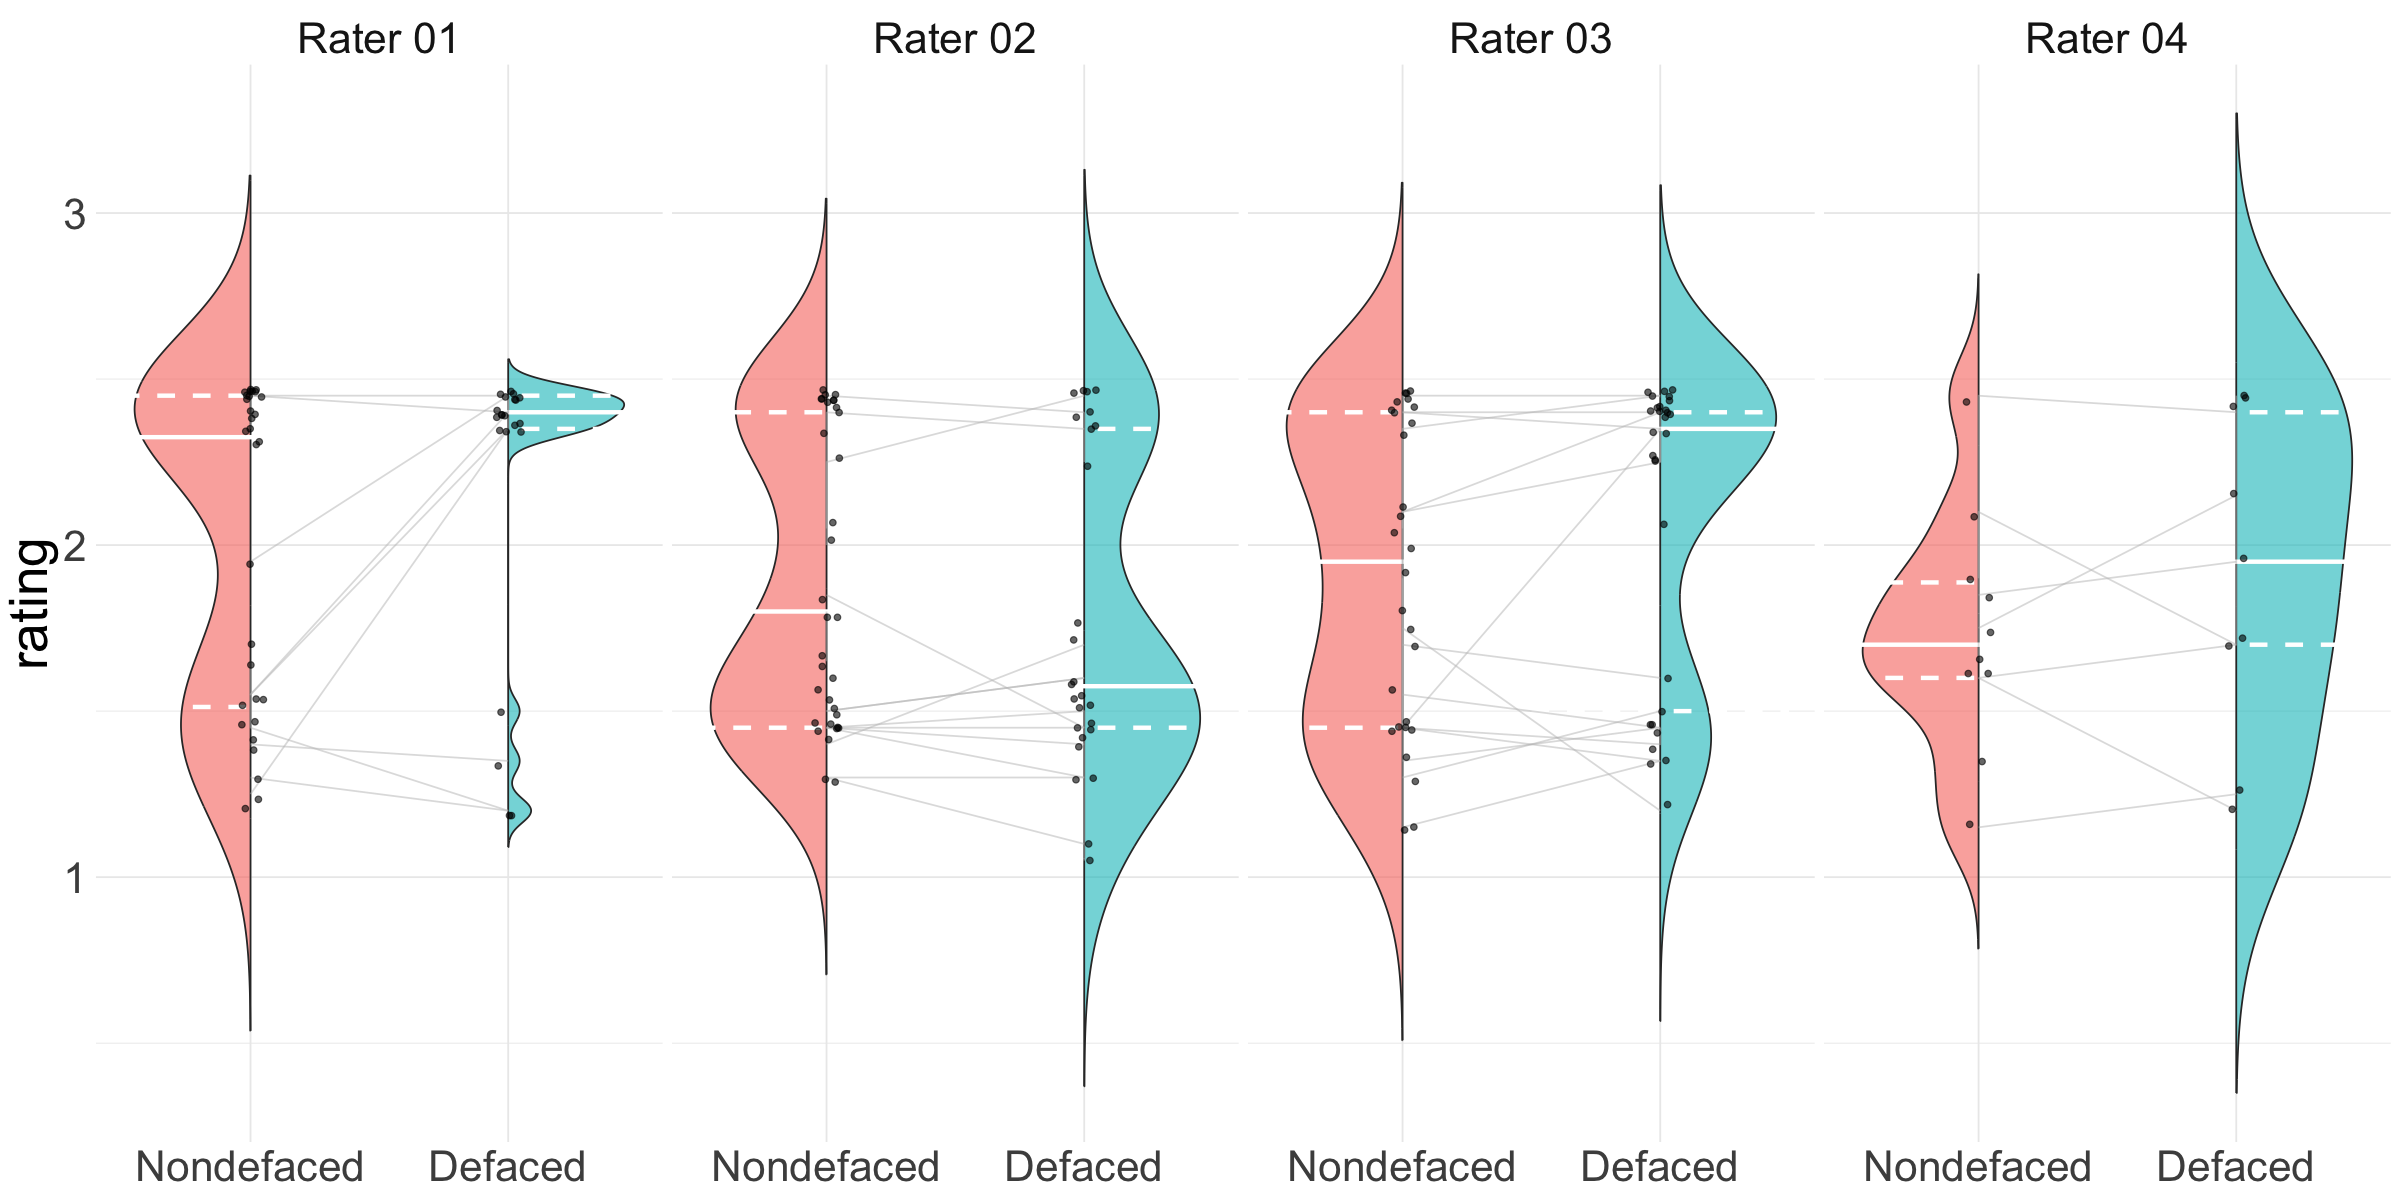

In [85]:
library(see)
df_poor <-  df%>%
  filter(rating <= 2.45)
nrow(df_poor)

p <- ggplot(df_poor, aes(x = defaced, y = rating, group = defaced)) +
  geom_violinhalf(aes(fill = defaced), trim = FALSE, scale = "width", alpha = 0.6, flip=c(0,1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.position = "none") +
  theme(axis.title.x = element_blank()) +
  facet_wrap(~ rater_label, ncol = 4)
print(p)

# Intra-rater reliability
## Violin and line plot

In [86]:
# Identify duplicates as rows that share the same rater_id using dplyr, defaced condition and subject. Those are the 40 subjects that we presented twice in both conditions to assess the intra-rater variability.
df_intra <- df %>% group_by(rater_id, subject) %>% filter(n() > 2)

#Verify that 40 duplicated subjects are found
print(length(unique(df_intra$subject)))

#Add a column in the dataset encoding whether it is the first or the second time the image is presented to this rater 
df_intra$presentation <- ifelse(duplicated(df_intra[, c("subject", "rater_id", "defaced")]), "Second", "First")

df_intra$randomized_id <- NULL

nrow(df_intra)
head(df_intra)

[1] 40


[1] 640

rater_id rating defaced    subject rater_label presentation
1 rater_02 2.55   Defaced     72     Rater 02    First       
2 rater_02 2.95   Defaced    248     Rater 02    First       
3 rater_02 2.55   Nondefaced 437     Rater 02    First       
4 rater_02 2.60   Nondefaced 614     Rater 02    First       
5 rater_02 2.65   Nondefaced 525     Rater 02    First       
6 rater_02 3.55   Defaced    335     Rater 02    First

We visualize the evolution of ratings from defaced versus non-defaced images for each rater.

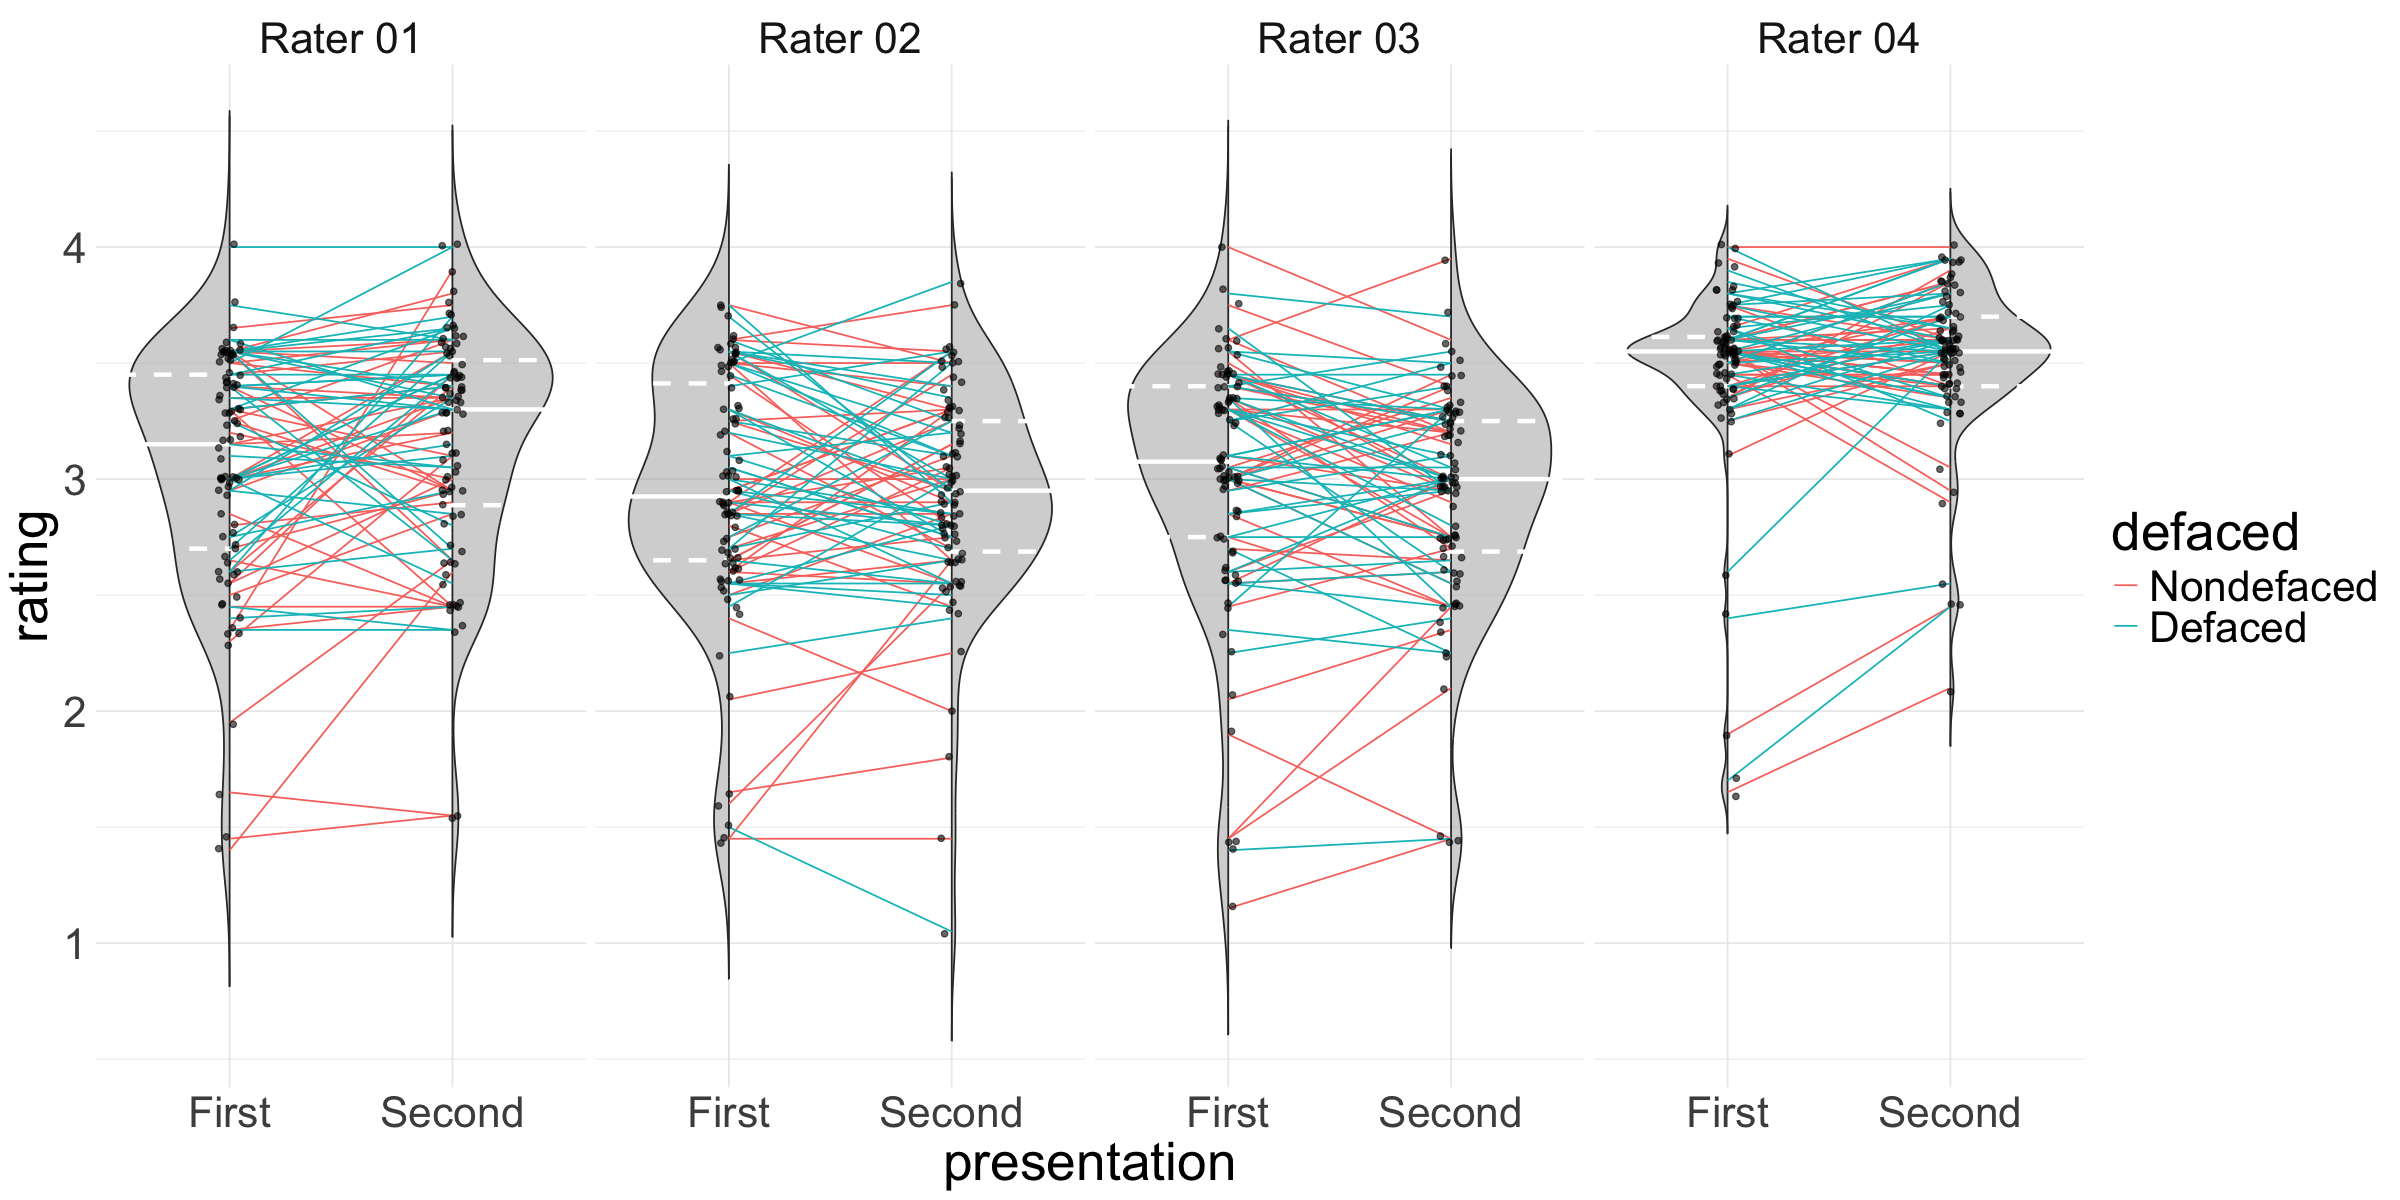

In [87]:
p <- ggplot(df_intra, aes(x = presentation, y = rating, group = presentation)) +
  geom_violinhalf(aes(fill = presentation), trim = FALSE, scale = "width", alpha = 0.5, flip=c(0,1), fill = "darkgrey") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = interaction(subject, defaced), color = defaced), alpha = 1) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  facet_wrap(~ rater_label, ncol = 4)
print(p)

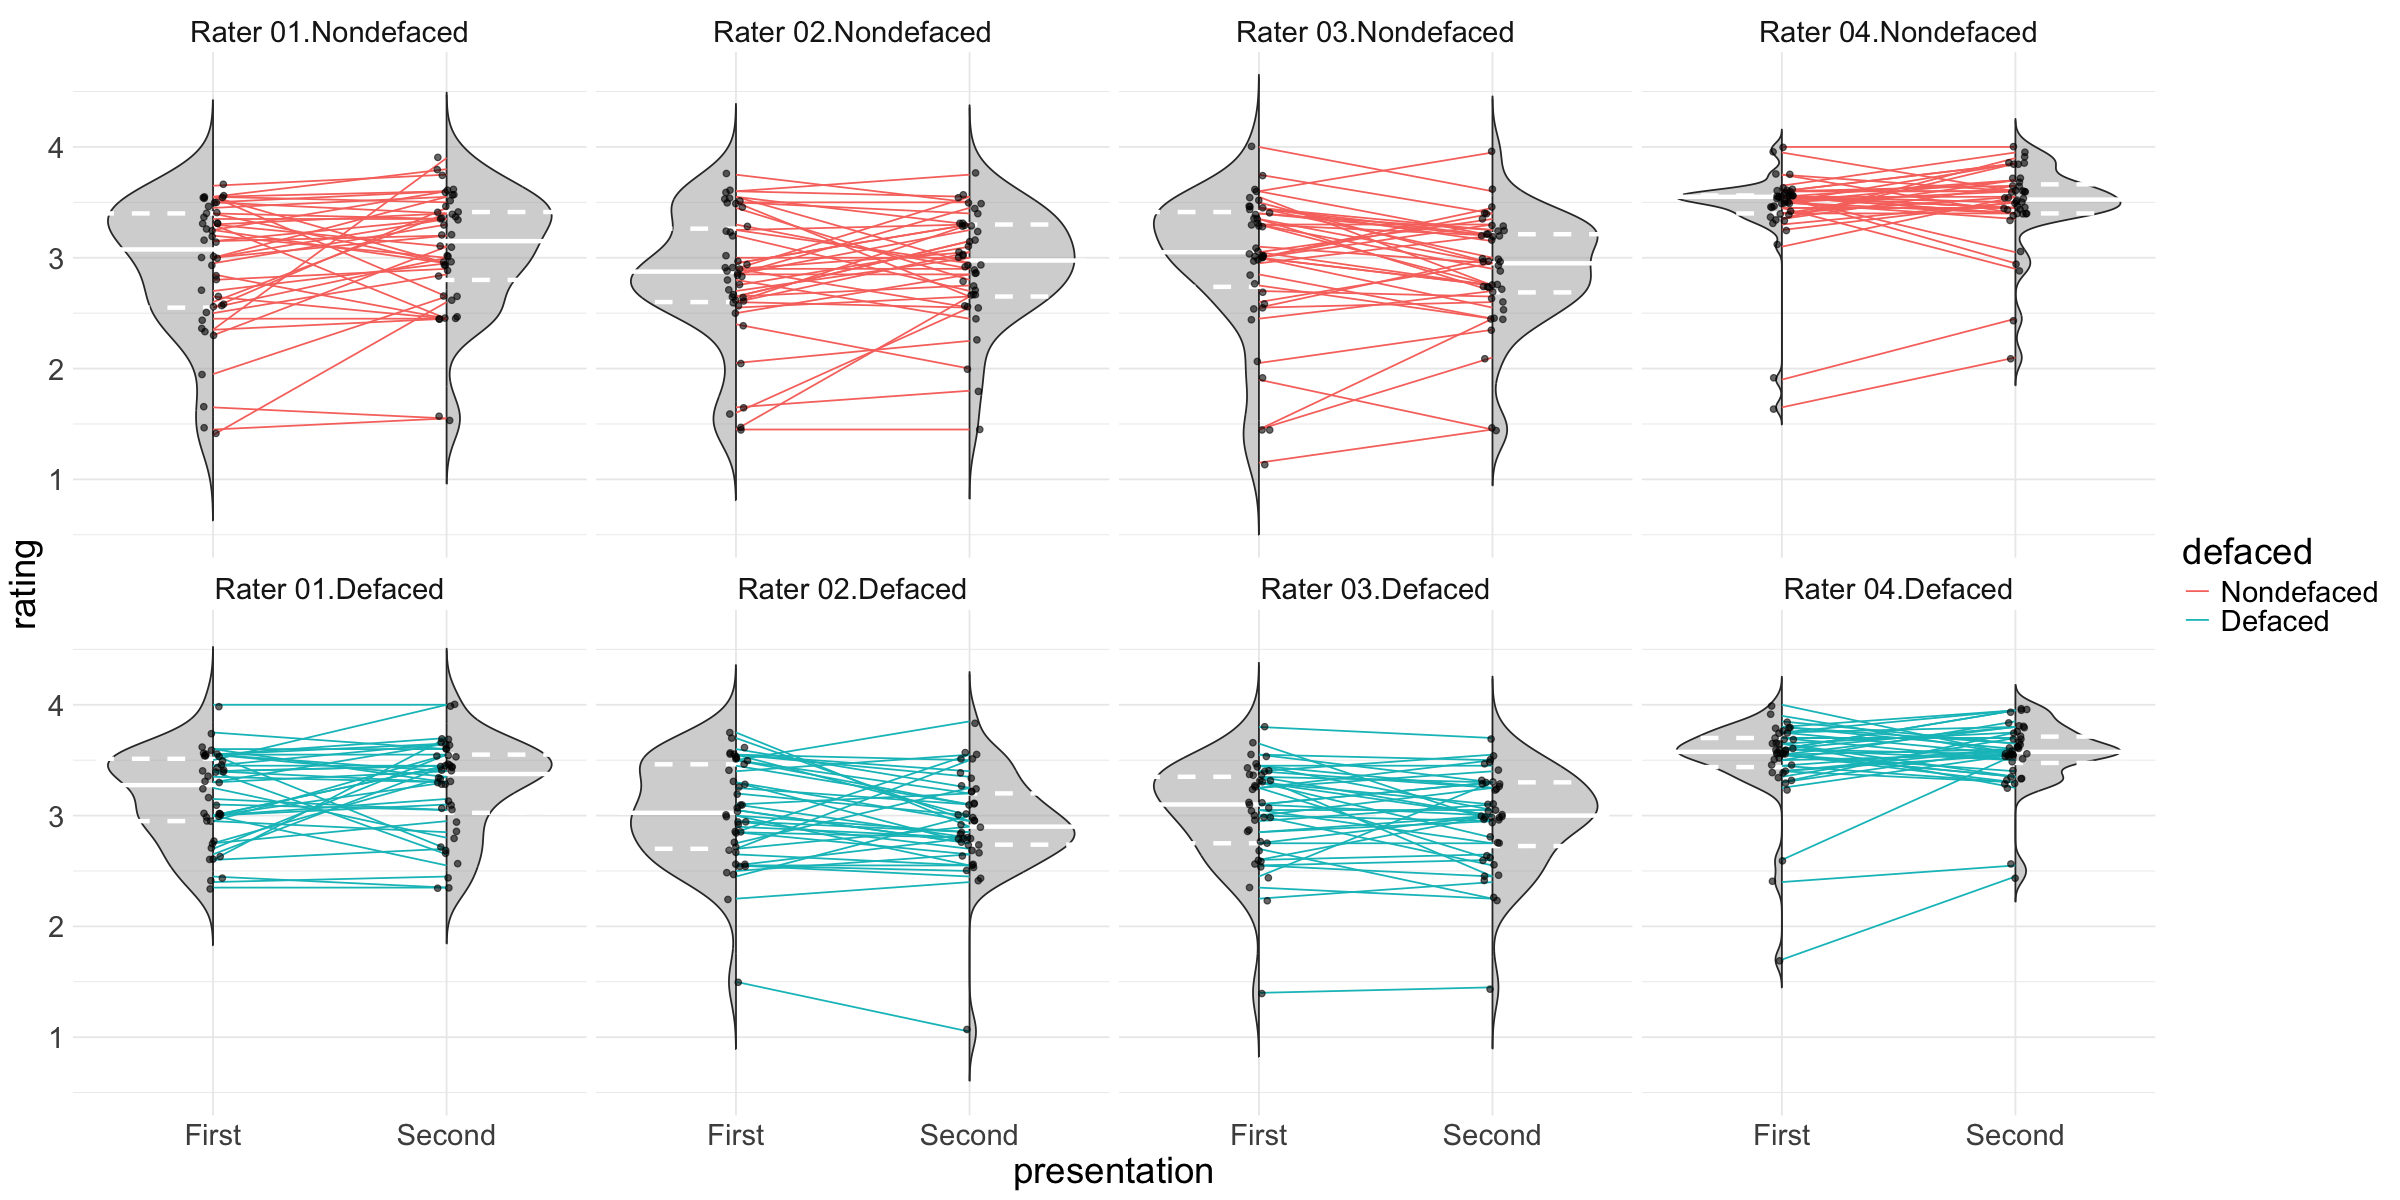

In [88]:
p <- ggplot(df_intra, aes(x = presentation, y = rating, group = presentation)) +
  geom_violinhalf(aes(fill = presentation), trim = FALSE, scale = "width", alpha = 0.5, flip=c(0,1), fill = "darkgrey") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = interaction(subject, defaced), color = defaced), alpha = 1) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ interaction(rater_label, defaced), ncol = 4)
print(p)

## Bland-Altman plot with mean on x-axis

[1] "Biases:"
[[1]]
[1] -0.11375

[[2]]
[1] 0.009375

[[3]]
[1] 0.07875

[[4]]
[1] -0.05125

[[5]]
[1] -0.01921875



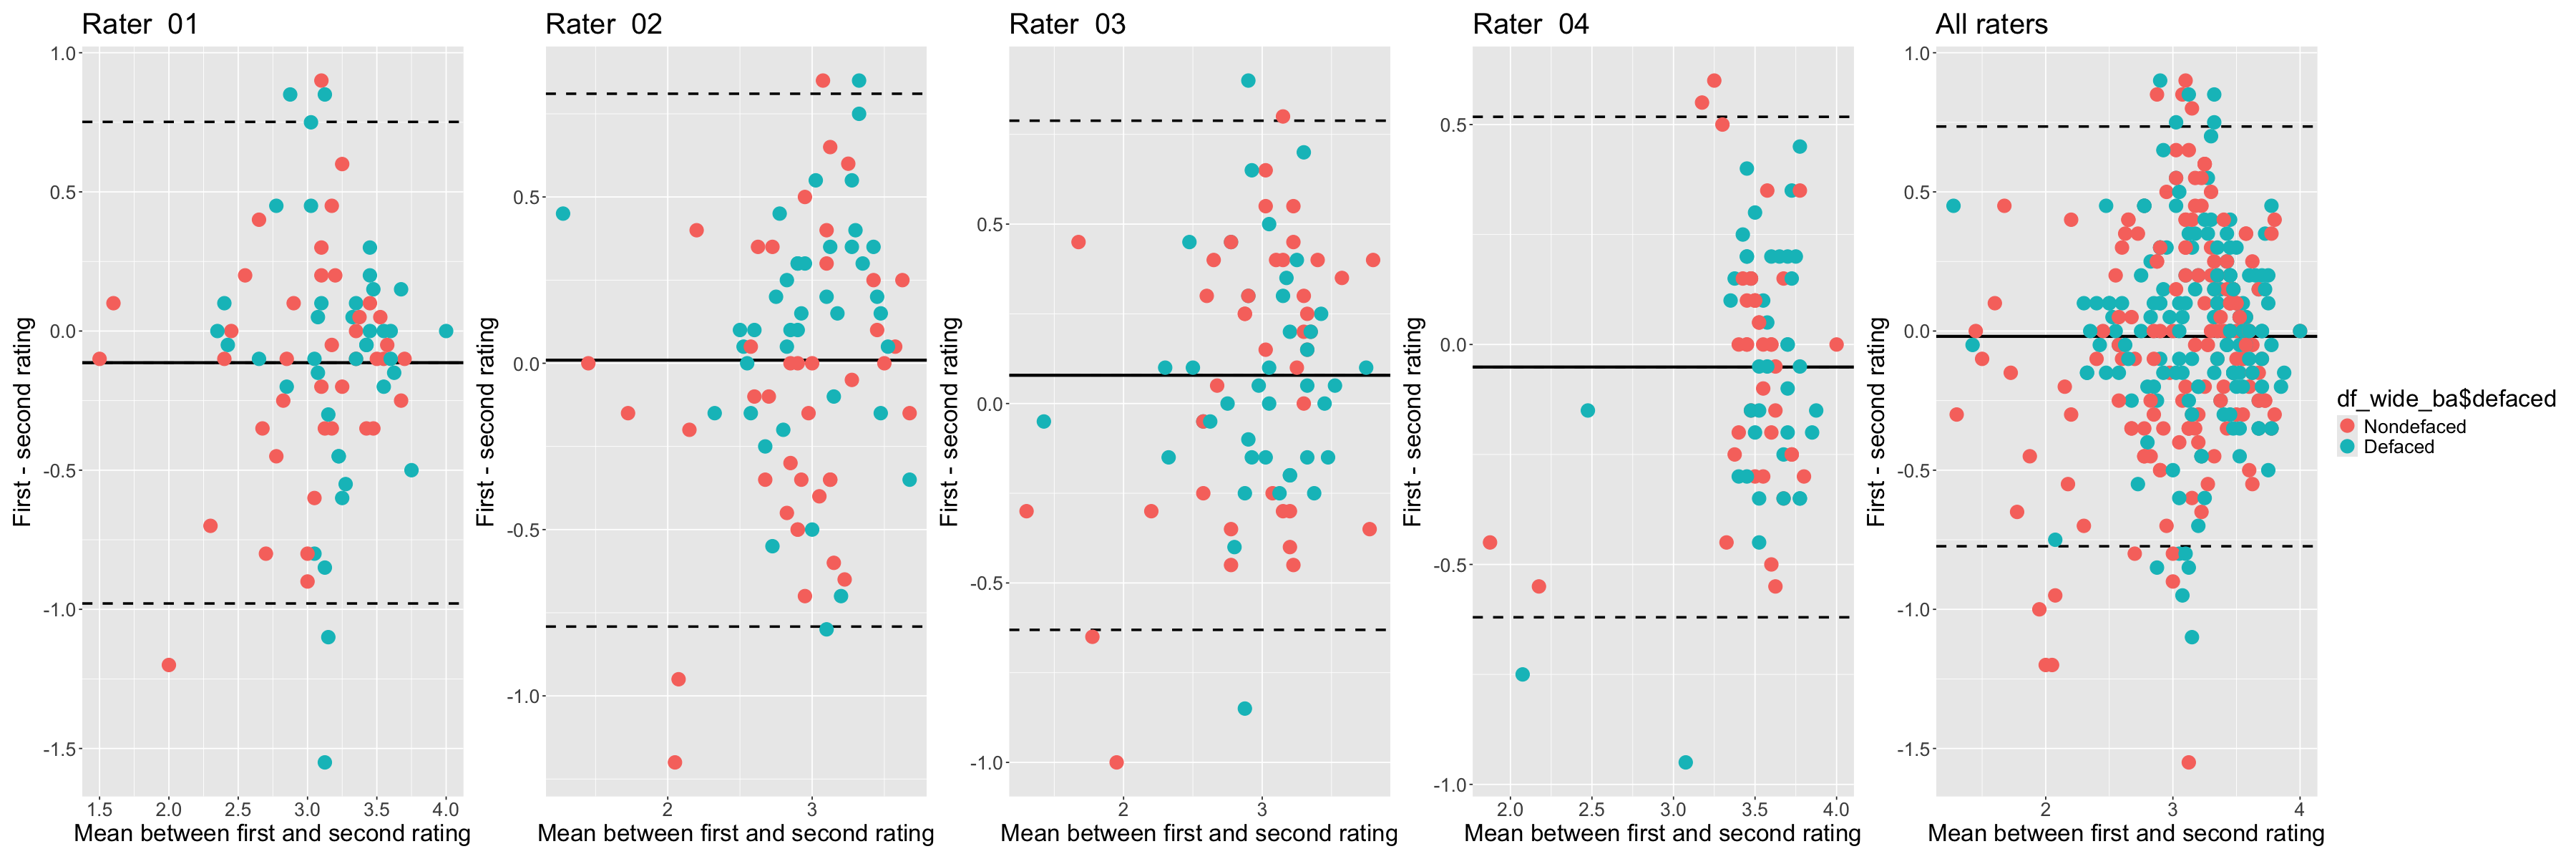

In [89]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales)
library(patchwork)
library(BlandAltmanLeh)
options(repr.plot.width=30, repr.plot.height=10)

## BA for each rater separately
#extract list of unique value in df$rater_id
plot_list <- list()
biases <- list()
for (rater in sort(unique(df$rater_id))) {
  #Keep only the rows corresponding to the rater and defaced condition
  df_rater <- subset(df_intra, rater_id == rater)
  df_rater_wide <- df_rater %>%
    pivot_wider(names_from = presentation, values_from = rating)
  
  #Compute bias which corresponds to mean difference
  df_rater_wide <- df_rater_wide %>%
    mutate(diff = First - Second)
  biases <- c(biases, list(mean(df_rater_wide$diff)))

  ba <- bland.altman.plot(df_rater_wide$First, df_rater_wide$Second, graph.sys="ggplot2") +
    geom_hline(yintercept = mean(df_rater_wide$diff), linetype = "solid", color = "black", size=1.2) +
    geom_point(aes(color = df_rater_wide$defaced), size = 5) +
    theme(text = element_text(size = 20)) +
    xlab("Mean between first and second rating") +
    ylab("First - second rating") +
    ggtitle(paste("Rater ", strsplit(rater, "_")[[1]][[2]])) +
    theme(legend.position = "none")

  plot_list <- c(plot_list, list(ba))
}

## BA plot with all raters
df_wide_ba <- df_intra %>%
  pivot_wider(names_from = presentation, values_from = rating)

# Compute bias which corresponds to mean difference
df_wide_ba <- df_wide_ba %>%
  mutate(diff = First - Second)
biases <- c(biases, list(mean(df_wide_ba$diff)))

ba_all <- bland.altman.plot(df_wide_ba$First, df_wide_ba$Second, graph.sys="ggplot2") +
    geom_hline(yintercept = mean(df_wide_ba$diff), linetype = "solid", color = "black", size=1.2) +
    geom_point(aes(color = df_wide_ba$defaced), size = 5) +
    theme(text = element_text(size = 20)) +
    xlab("Mean between first and second rating") +
    ylab("First - second rating") +
    ggtitle("All raters")

plot_list <- c(plot_list, list(ba_all))

## Combine plots
combined_plot <- wrap_plots(plot_list, ncol = 5) 

print(combined_plot)

print("Biases:")
print(biases)

## Bland-Altman plot with first ratings on x-axis

In [90]:
library(dplyr)
#Helper function to generate BA plot
ba_plot_intrarater <- function(df, title, rater, point_size = 2.5, color_1="#F5C241", color_2="#643296", line_color="grey", yaxis = "diff") {

  # Pivot to wide format
  df_wide_ba <- df %>%
      pivot_wider(names_from = presentation, values_from = rating, values_fn = list)

  #Decouple the duplicates by writing the first image rating in one line and the second in a new line
  df_wide_ba <- df_wide_ba %>%
    unnest(cols = c("First", "Second"))

  df_wide_ba <- df_wide_ba %>%
    mutate(mean = First,
          diff = First - Second,
          pt_color = case_when(
            diff < -0.5 ~ color_2,
            diff > 0.5 ~ color_1,
            diff > 0.1 ~ color_12,
            diff < -0.1 ~ color_22,
            TRUE ~ color_reliable
          ))

  if (!missing(rater)) {
    #Keep only the rows corresponding to the rater
    df_rater <- subset(df, rater_id == rater)

    #Pivot to wide format
    df_rater_wide <- df_rater %>%
      pivot_wider(names_from = presentation, values_from = rating, values_fn = list)

    #Decouple the duplicates by writing the first image rating in one line and the second in a new line
    df_rater_wide <- df_rater_wide %>%
      unnest(cols = c("First", "Second"))

    #Create a new column encoding the mean and color to plot the points
    df_rater_wide <- df_rater_wide %>%
      mutate(mean = First,
            diff = First - Second,
            pt_color = case_when(
              diff < -0.5 ~ color_2,
              diff > 0.5 ~ color_1,
              diff > 0.1 ~ color_12,
              diff < -0.1 ~ color_22,
              TRUE ~ color_reliable
          ))

    # Calculate mean difference and 1.96 times the standard deviation of the differences
    mean_diff <- mean(df_rater_wide$diff)
    sd_diff <- sd(df_rater_wide$diff)
    upper_limit <- mean_diff + 1.96 * sd_diff
    lower_limit <- mean_diff - 1.96 * sd_diff

    if (yaxis == "diff"){
    ba <- ggplot(df_rater_wide, aes(x = mean, y = diff)) +
      geom_point(data = df_wide_ba, aes(x = mean, y = diff, color="#d9d9d9"), alpha = 0.3, size=point_size) +
      geom_point(size = point_size, aes(color = pt_color))
    } else if (yaxis == "second") {
      ba <- ggplot(df_rater_wide, aes(x = mean, y = Second)) +
      geom_point(data = df_wide_ba, aes(x = mean, y = Second, color="#d9d9d9"), alpha = 0.3, size = point_size) +
      geom_point(size = point_size, aes(color = pt_color)) +
      geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", color = color_reliable)
    }
  } else {
    # Calculate mean difference and 1.96 times the standard deviation of the differences
    mean_diff <- mean(df_wide_ba$diff)
    sd_diff <- sd(df_wide_ba$diff)
    upper_limit <- mean_diff + 1.96 * sd_diff
    lower_limit <- mean_diff - 1.96 * sd_diff

    if (yaxis == "diff"){
      ba <- ggplot(df_wide_ba, aes(x = mean, y = diff)) +
        geom_point(size = point_size +1, aes(color = pt_color))
    } else if (yaxis == "defaced") {
      ba <- ggplot(df_wide_ba, aes(x = mean, y = Second)) +
        geom_point(size = point_size +1, aes(color = pt_color)) +
        geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", color = color_reliable)
    }
  }

  ba <- ba +
    # geom_hline(yintercept = 0, color = "#7f7f7f", linetype = "solid", size = 1) +
    # geom_hline(yintercept = mean_diff, color = line_color, linetype = "solid", size = 1) +
    # geom_hline(yintercept = upper_limit, color = line_color, linetype = "dashed", size = 1) +
    # geom_hline(yintercept = lower_limit, color = line_color, linetype = "dashed", size = 1) +
    scale_color_identity() +
    theme(legend.position = "none") +
    # theme(text = element_text(size = 19, face="bold")) +
    theme(
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
    ) +
    theme(panel.background = element_blank()) +
    xlab("") +
    ylab("")

  if (!missing(title)) {
    # ba <- ba + ggtitle(title)
    write_y <- if (yaxis == "diff") 2.0 else 4.4
    ba <- ba + annotate(
      "text",
      label = title,
      x = 3.9, # max(df_wide_ba$Nondefaced),
      y = write_y,  # min(df_wide_ba$diff),
      hjust = 1,
      size = 10,
      fontface = 1,
    )
  }

  if (yaxis=="diff"){
    ba <- ba + 
      xlim(0.9, 4.1) +
      ylim(-2.1, 2.1)
  }

  return(ba)
}

ba_figure_intrarater <- function(df, title) {
  library(ggplot2)
  library(grid)
  library(gridExtra)
  library(dplyr)
  library(scales)
  options(repr.plot.width=13, repr.plot.height=8)

  plot_list <- list()

  point_size <- 2.5

  ## BA plot with all raters
  ba_all <- ba_plot_intrarater(df = df, title = "All raters")

  ba_all <- ba_all +
      geom_segment(
        x = 1.2, y = -1.6,
        xend = 4.0, yend = -1.6,
        lineend = "round", # See available arrow types in example above
        linejoin = "round",
        size = 0.8, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = "black",
      )

  if (title == "Non-defaced"){
    # Assuming ba_nd and ba_d are your initial ggplot objects
    ba_all <- ba_all +
      geom_segment(
        x = 0.95, y = 0.52,
        xend = 0.95, yend = 2.0,
        lineend = "round",
        linejoin = "round",
        size = 1, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = color_1
      ) +
      geom_segment(
        x = 0.95, y = 0.52,
        xend = 0.99, yend = 0.52,
        color = color_1,
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = -0.52,
        xend = 0.95, yend = -2.0,
        lineend = "round",
        linejoin = "round",
        size = 1, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = color_2
      ) +
      geom_segment(
        x = 0.95, y = -0.52,
        xend = 0.99, yend = -0.52,
        color = color_2,
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = -0.48,
        xend = 0.95, yend = 0.48,
        color = "#7f7f7f",
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = -0.48,
        xend = 0.99, yend = -0.48,
        color = "#7f7f7f",
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = 0.48,
        xend = 0.99, yend = 0.48,
        color = "#7f7f7f",
        size = 1
      )
  } 

  # Adjust plot margins
  ba_all <- ba_all + theme(
    plot.margin = unit(c(1,0,0,1), "cm"),
  )

  plot_list <- c(list(ba_all), plot_list)

  ## BA for each rater
  for (rater in sort(unique(df$rater_id))) {
    rater_title = paste("Rater ", strsplit(rater, "_")[[1]][[2]])
    ba  <- ba_plot_intrarater(df = df, title = rater_title, rater = rater)
    plot_list <- c(plot_list, list(ba))
  }
  
  lay <- rbind(c(1,1,1,2,2,3,3),
              c(1,1,1,4,4,5,5))
  final_plot <- grid.arrange(
    grobs = plot_list,
    # bottom=x_grob,
    # left=y_grob,
    layout_matrix = lay,
    )

  return(final_plot)
}

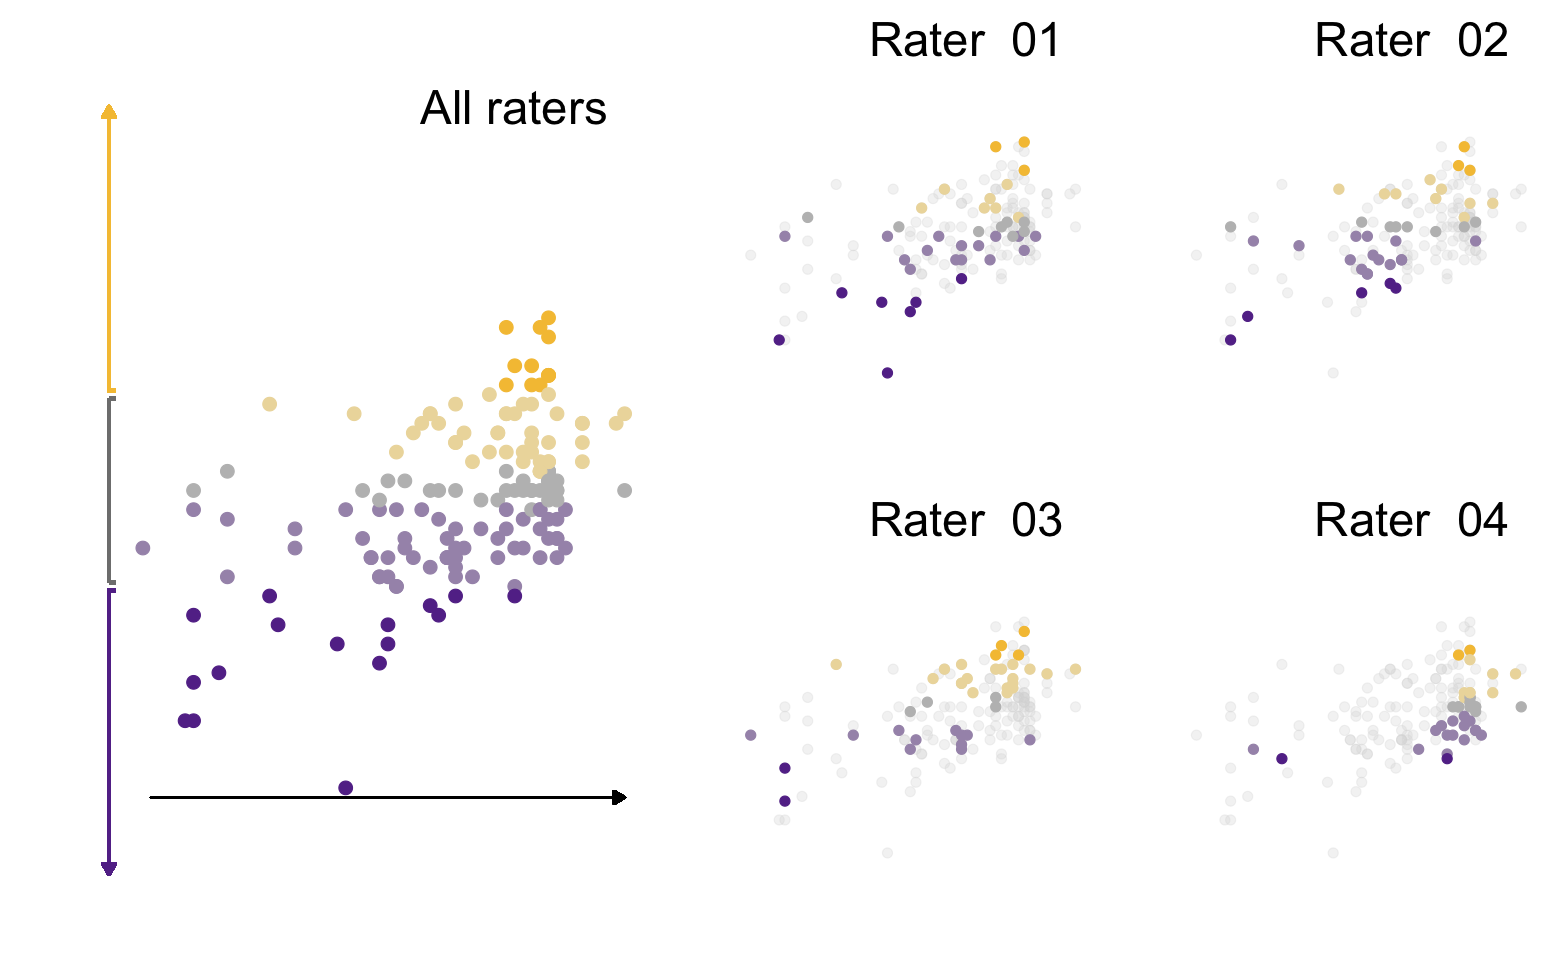

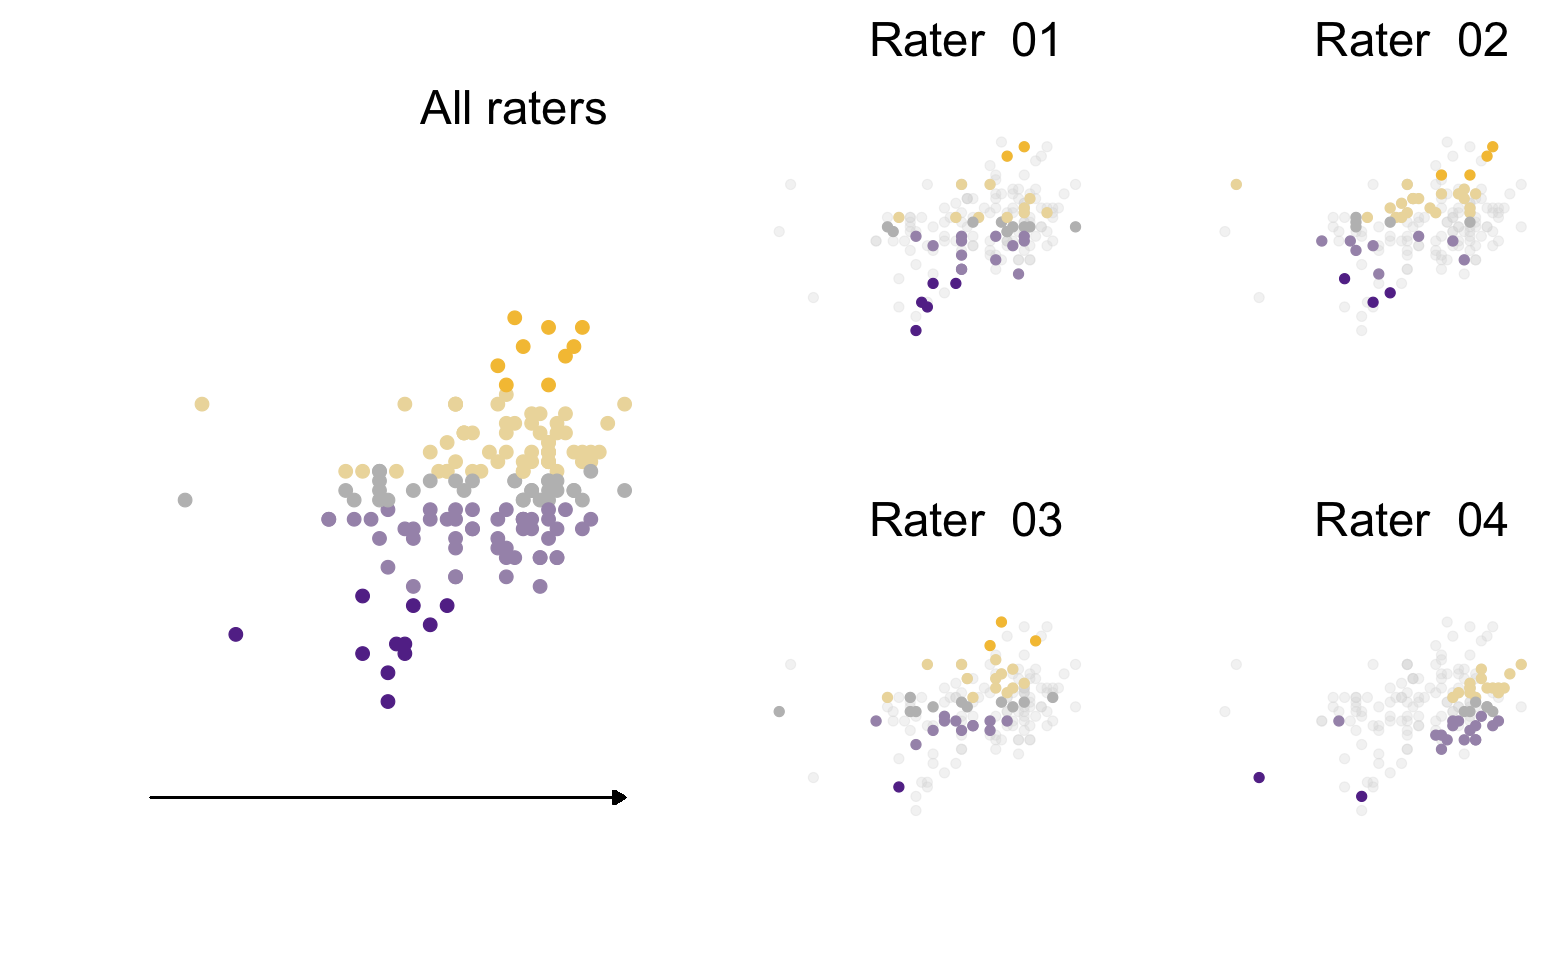

In [91]:
library(ggplot2)
library(gridExtra)
library(grid)

ba_nd <- ba_figure_intrarater(subset(df_intra, defaced == "Nondefaced"), title="Non-defaced")
ba_d <- ba_figure_intrarater(subset(df_intra, defaced == "Defaced"), title="Defaced")

options(repr.plot.width=26, repr.plot.height=8)

# Create text annotations
comment_grob <- textGrob(
  "Second\noverestimated",
  gp = gpar(fontsize = 23, col= color_2, lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.25,
  just = c("centre", "top")
)
comment_grob_2 <- textGrob(
  "Second\nunderestimated",
  gp = gpar(fontsize = 23, col= color_1, lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.75,
  just = c("centre", "top")
)
comment_grob_3 <- textGrob(
  "Consistent\nratings",
  gp = gpar(fontsize = 23, col = "#7f7f7f", lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.5,
  just = c("centre", "top")
)

comment_grob_xaxis1 <- textGrob(
    "x-axis shows first ratings\n('excellent' ratings to the right)",
    gp = gpar(fontsize = 18, col = "black", lineheight = 0.8),
    x = 0.13,
    y = 0.165,
    just = c("centre", "top"))

comment_grob_xaxis2 <- textGrob(
    "x-axis shows first ratings\n('excellent' ratings to the right)",
    gp = gpar(fontsize = 18, col = "black", lineheight = 0.8),
    x = 0.63,
    y = 0.165,
    just = c("centre", "top"))

title_grob1 <- textGrob("Non-defaced", 
    gp = gpar(fontsize = 32, fontface = 2), 
    x = 0.01,
    y = 0.98,
    just = c("left", "top")
  )

title_grob2 <- textGrob("Defaced", 
    gp = gpar(fontsize = 32, fontface = 2), 
    x = 0.55,
    y = 0.98,
    just = c("left", "top")
  )

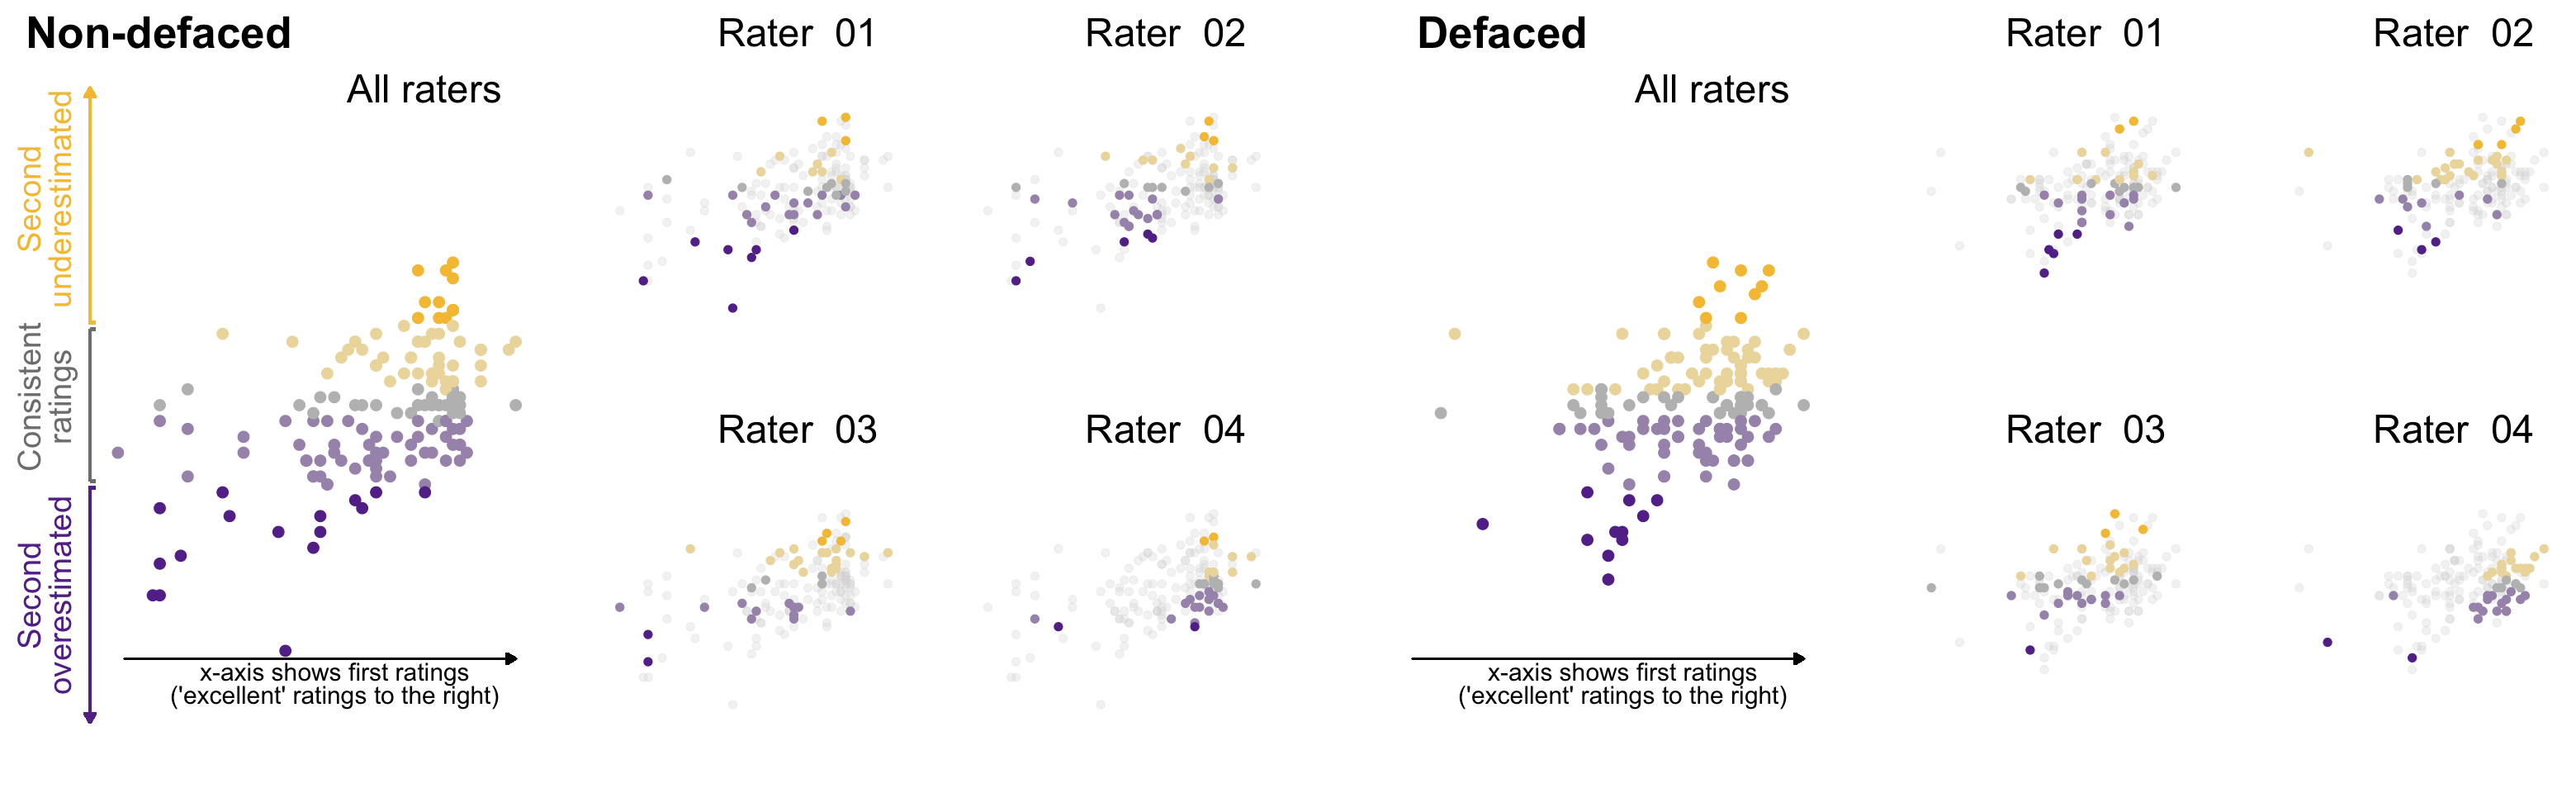

In [92]:
# Combine the plots into a single figure
combined_plot <- grid.arrange(ba_nd, ba_d, ncol = 2)

# Draw the combined plot
grid.draw(combined_plot)

# Add the text annotations
grid.draw(comment_grob)
grid.draw(comment_grob_2)
grid.draw(comment_grob_3)
grid.draw(comment_grob_xaxis1)
grid.draw(comment_grob_xaxis2)
grid.draw(title_grob1)
grid.draw(title_grob2)

## Intra-rater reliability

Let's quantify intra-rater reliability using intraclass correlation (ICC)

In [93]:
#To compute ICC, the data needs to be in wide format
library(tidyr)

df_intra_wide <- df_intra %>%
  pivot_wider(names_from = presentation, values_from = rating)

#Add a column that encodes the interaction between defaced and subject
df_intra_wide$image <- interaction(df_intra_wide$defaced, df_intra_wide$subject)
df_intra_wide$defaced <- NULL
df_intra_wide$subject <- NULL
df_intra_wide$rater_label <- NULL
head(df_intra_wide)

rater_id First Second image         
1 rater_02 2.55  2.55   Defaced.72    
2 rater_02 2.95  2.85   Defaced.248   
3 rater_02 2.55  2.65   Nondefaced.437
4 rater_02 2.60  3.05   Nondefaced.614
5 rater_02 2.65  2.75   Nondefaced.525
6 rater_02 3.55  3.00   Defaced.335

In [94]:
# Compute ICC two way mixed effects model and consider absolute agreement
library("irr")

df_intra_wide$image <- NULL

#extract list of unique value in df$rater_id
for (rater in unique(df$rater_id)) {
  #Keep only the rows corresponding to the rater
  df_rater <- subset(df_intra_wide, rater_id == rater)
  df_rater$rater_id <- NULL

  print(sprintf('Intra-rater reliability for %s', rater))
  print(icc(df_rater, model="twoway", type="agreement"))
}


[1] "Intra-rater reliability for rater_02"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 80 
     Raters = 2 
   ICC(A,1) = 0.676

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(79,79.1) = 5.12 , p = 2.85e-12 

 95%-Confidence Interval for ICC Population Values:
  0.536 < ICC < 0.779
[1] "Intra-rater reliability for rater_03"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 80 
     Raters = 2 
   ICC(A,1) = 0.746

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(79,75.6) = 7.09 , p = 8.37e-16 

 95%-Confidence Interval for ICC Population Values:
  0.63 < ICC < 0.83
[1] "Intra-rater reliability for rater_01"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 80 
     Raters = 2 
   ICC(A,1) = 0.609

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(79,72.5) = 4.29 , p = 9.88e-10 

 95%-Confidence Interval for ICC Population Values:
  0.449 < ICC < 0.731
[1] "Intra-rater reliability for rater_

# Inter-rater reliability

Similarly to intra-rater reliability, we will quantify inter-rater reliability using intraclass correlation (ICC).

In [95]:
library(dplyr)
library(tidyr)
library(purrr)

df_filtered <- subset(df, select = -c(rater_label))

df_wide <- df_filtered %>%
  pivot_wider(names_from = rater_id, values_from = rating, values_fn = list, names_sort = TRUE)

In [96]:
#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide <- df_wide %>%
  unnest(cols = c(rater_02, rater_03, rater_04, rater_01))
nrow(df_wide)
head(df_wide)


[1] 450

defaced    subject rater_01 rater_02 rater_03 rater_04
1 Defaced     72     2.60     2.55     3.55     2.40    
2 Defaced     72     2.70     2.55     3.30     2.55    
3 Nondefaced 354     3.05     2.85     3.70     3.70    
4 Nondefaced 205     3.55     2.55     3.30     3.70    
5 Defaced    446     3.40     3.45     3.35     3.95    
6 Defaced    248     2.70     2.95     3.30     3.70

In [97]:
library("irr")

df_wide$defaced <- NULL
df_wide$subject <- NULL
print(icc(df_wide, model="twoway", type="consistency"))

 Single Score Intraclass Correlation

   Model: twoway 
   Type : consistency 

   Subjects = 450 
     Raters = 4 
   ICC(C,1) = 0.542

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
F(449,1347) = 5.74 , p = 5.9e-137 

 95%-Confidence Interval for ICC Population Values:
  0.497 < ICC < 0.587


# Reliability of the ratings between non-defaced and defaced conditions

In [98]:
library(dplyr)
library(tidyr)
library(purrr)
library("irr")

df_filtered <- subset(df, select = -c(rater_label))

df_wide_defaced <- df_filtered %>%
  pivot_wider(names_from = defaced, values_from = rating, values_fn = list, names_sort = TRUE)

#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide_defaced <- df_wide_defaced %>%
  unnest(cols = c("Nondefaced", "Defaced"))
nrow(df_wide_defaced)
head(df_wide_defaced)

df_wide_defaced$rater_id <- NULL
df_wide_defaced$subject <- NULL
print(icc(df_wide_defaced, model="twoway", type="consistency"))

[1] 900

rater_id subject Nondefaced Defaced
1 rater_02  72     2.40       2.55   
2 rater_02  72     2.00       2.55   
3 rater_02 354     2.85       2.55   
4 rater_02 205     2.55       3.60   
5 rater_02 446     3.55       3.45   
6 rater_02 248     3.20       2.95

 Single Score Intraclass Correlation

   Model: twoway 
   Type : consistency 

   Subjects = 900 
     Raters = 2 
   ICC(C,1) = 0.697

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(899,899) = 5.6 , p = 2.56e-132 

 95%-Confidence Interval for ICC Population Values:
  0.662 < ICC < 0.729


# Rating evolution through time

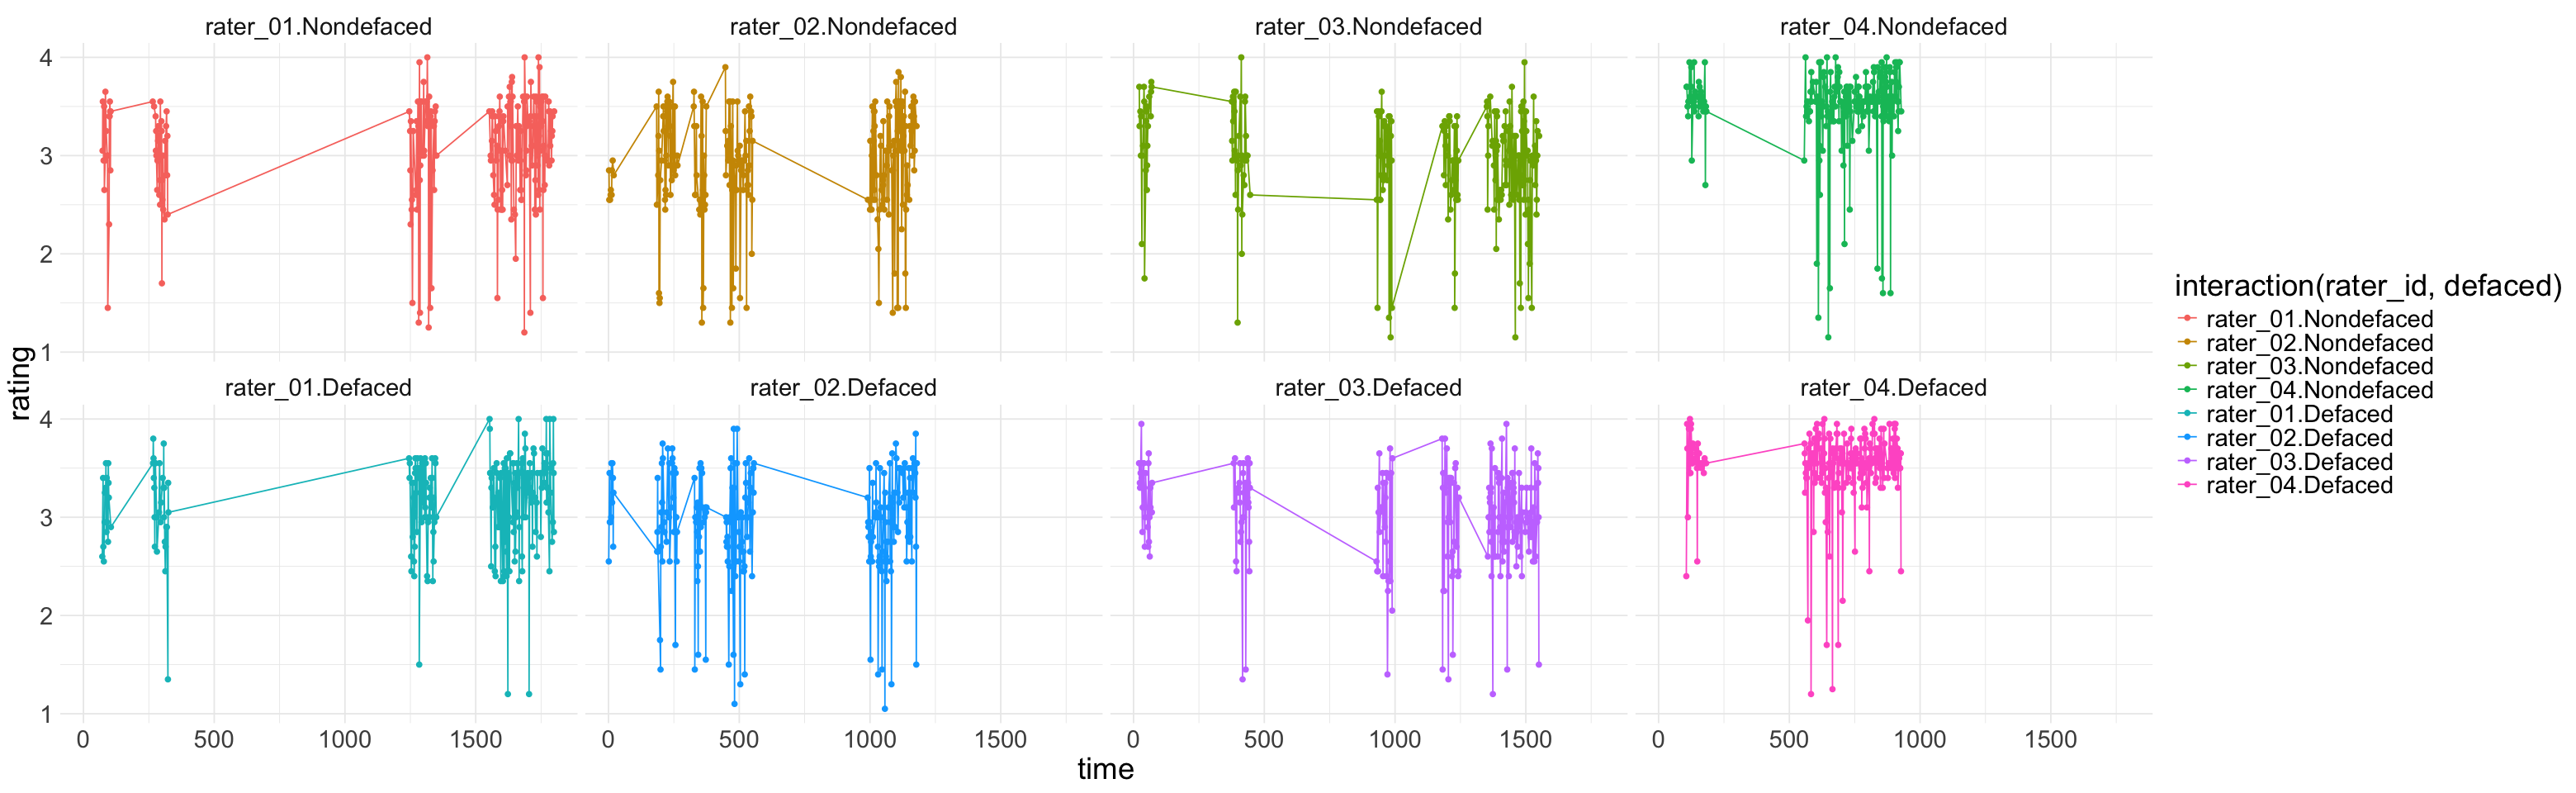

In [99]:
# For each subgroup defined by rater_id and defaced condition, plot the rating evolution through time. 
df$time <- 1:nrow(df)
p <- ggplot(df, aes(x = time, y = rating, group = interaction(rater_id, defaced), color = interaction(rater_id, defaced))) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ interaction(rater_id, defaced), ncol = 4)
print(p)

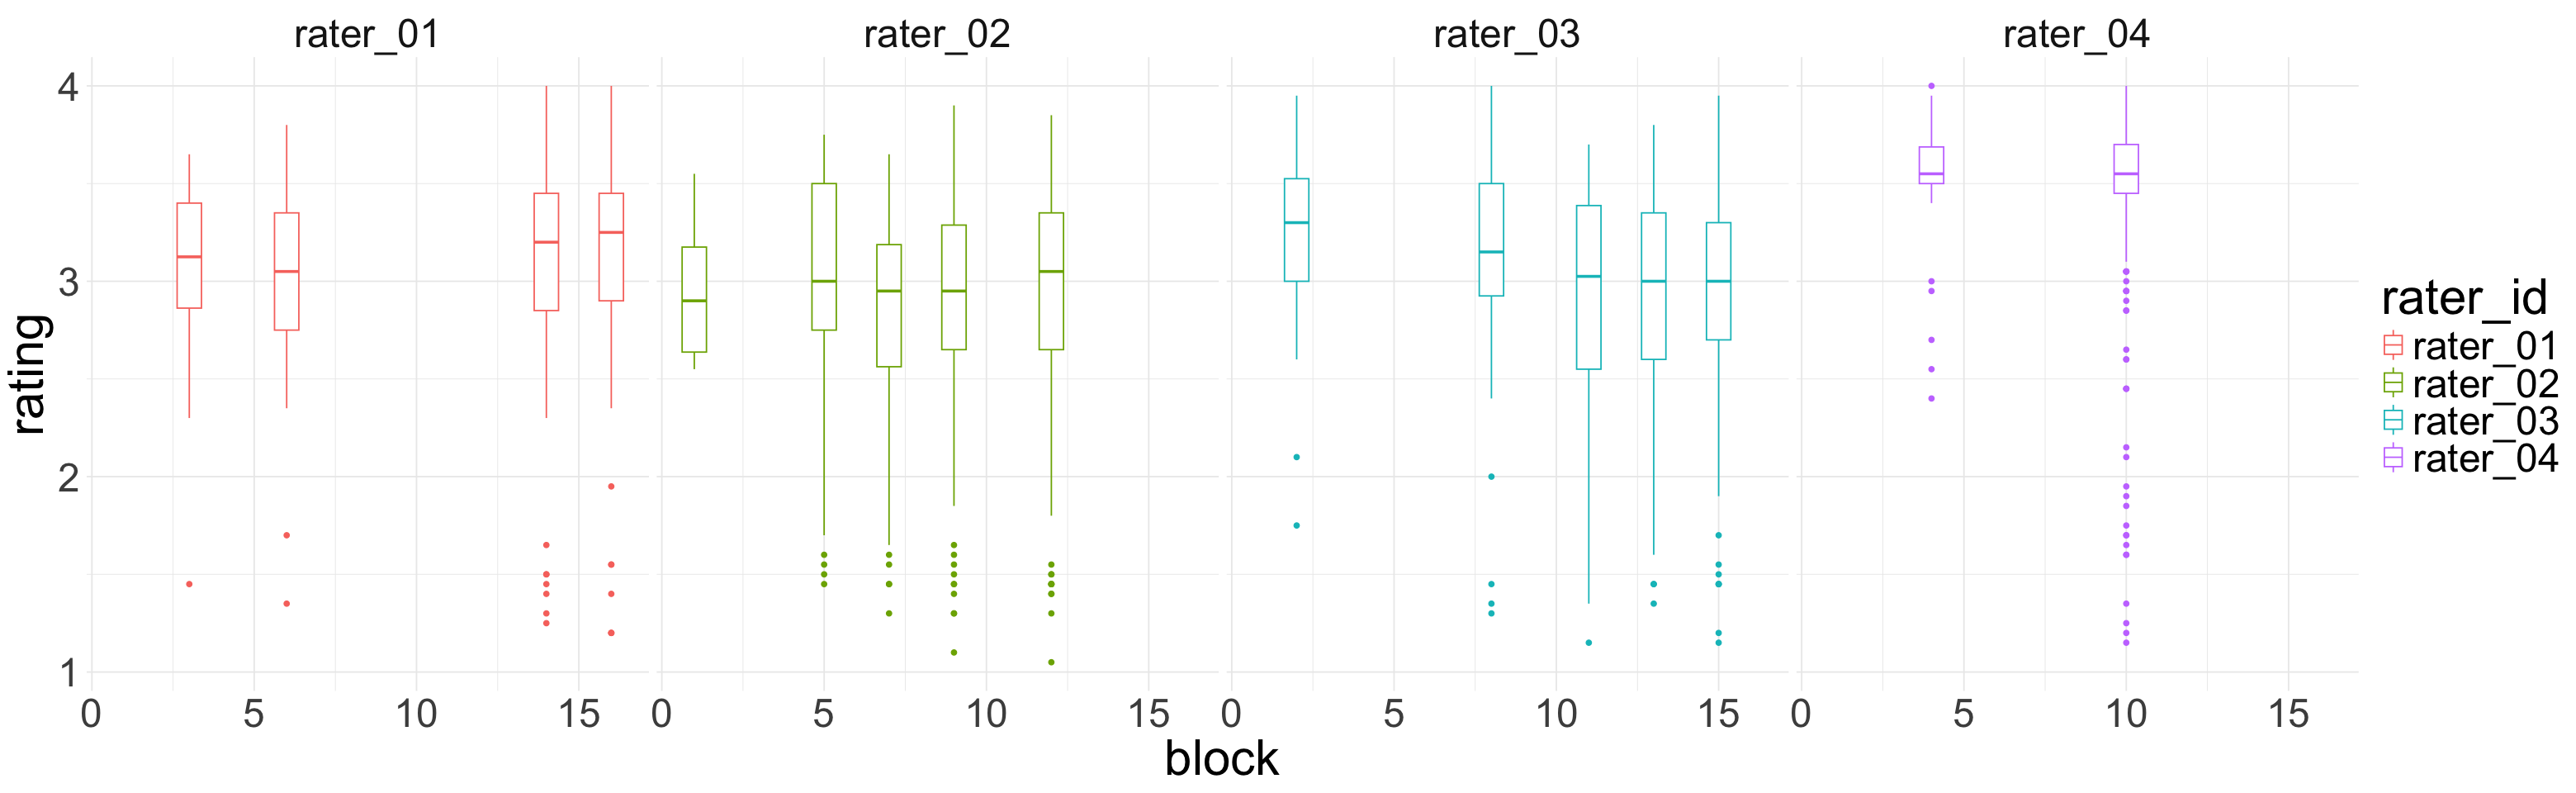

In [100]:
#Identify blocks of ratings from the same raters
rle_blocks <- rle(as.character(df$rater_id))
df$block <- rep(seq_along(rle_blocks$lengths), rle_blocks$lengths)

#For each block, plot a boxplot of the distribution of the ratings without differentiating between defaced and nondefaced
# order the block by rater_id
p <- ggplot(df, aes(x = block, y = rating, group = block, color=rater_id)) +
  geom_boxplot() +
  theme_minimal() +
  theme(text = element_text(size = 36)) +
  facet_wrap(~ rater_id, ncol = 4)

print(p)